# Samokat.tech Matching

## Описание проекта

**Matching** - это задача поиска и сопоставления двух объектов из разных наборов данных. Такая потребность возникла у маркетплейса, который имеет большой перечен товаров для продажи. На склад собираются поступить новые товары, которые могут имеет небольшие различия от уже существующих. Технически, это выглядит как совершенно новые товары. Фактически это те же товары, которые уже продаются на маркетплейсе. Задача сопоставить и связать новые (предлагаемые для продажи) товары со старыми, пользуясь совпадениями в характеристиках, описаниях и изображениях.

**Что надо сделать?**
- предстоит реализовать финальную часть пайплайна матчинга. В ней необходимо принять решение для каждой пары (товар предлагаемый продавцом — товар на площадке), является ли она матчем или нет (бинарная классификация).
- Для этого у каждой пары есть набор признаков и наборы векторов (картиночные и текстовые), которые описывают товары из этой пары.
- В качестве метрики качества решения используется _F-score_.

**Данные:** [источник](https://www.kaggle.com/competitions/binary-classification-offers-on-the-marketplace/data)

- `train.csv` - обучающий датасет. Содержит пары предложений и товаров, вероятность их мэтча, а так же другие параметры (id товаров, категория и др.)
- `test.csv` - датасет для итогового тестирования. Аналогичное содержание колонок, за исключения целевого признака.
- `sample_submission.csv` - пример файла предсказаний.

Каждое предложение и товар имеют изображение и название с атрибутами, которые в свою очередь представлены в векторном виде (эмбеддингах).
Embeddings:

- `goods_image_vectors` и `offer_image_vectors` - содержат файлы с векторами изображений (embed_deperson.npy) и их идентификаторами (items_deperson.npy) для товаров ассортимента и предложений соответственно. Объекты в файлах соотносятся 1 к 1.
- `goods_title_vectors` и `offer_title_vectors` - содержат файлы с векторами названий+атрибутов (embed_deperson.npy) и их идентификаторами (items_deperson.npy) для товаров ассортимента и предложений соответственно. Объекты в файлах соотносятся 1 к 1.

**План работы:**
- Загрузить данные
- Понять задачу
- Подготовить данные
- Обучить модель
- Измерить качество
- git commit
- Сделать лучше!

Примечание: ячейки кода, исполнение которы занимает продолжительное время, имеют функцию `%%time` и время исполнения, указанное в конце выходных данных.

___

## Подготовка

In [1]:
# импорт библиотек
import phik
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# импорт спец. модулей
from tqdm import tqdm
from scipy.stats import  scoreatpercentile
from scipy.spatial import distance
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (precision_score,
                             recall_score,
                             f1_score,
                             precision_recall_curve,
                             PrecisionRecallDisplay,
                             confusion_matrix,
                             ConfusionMatrixDisplay)

# константы
FIGSIZE = (14, 6)
RANDOM_STATE = 42
DATA_DIR = 'data/'
ITEMS_FILENAME = 'items_deperson.npy'
EMBEDDINGS_FILENAME = 'embed_deperson.npy'

In [28]:
# блок объявлений функций

def embed_info(embed:np.ndarray, index:np.ndarray) -> None:

    '''
    Функция принимает на вход массив данный numpy (эмбеддинги) и возвращает ключевую информацию по ним.
    '''

    # эмбеддинги товаров
    print('Пример векторизованных данных:\n', embed)
    print('Размер массива:', embed.shape)

    print('Макс. значение массива:', max(max(row) for row in embed))
    print('Мин. значение массива:', min(min(row) for row in embed))

    # массив id товаров
    print('\nПример массива индексов:\n', index)
    print('Размер массива:', index.shape)

    plt.boxplot(embed.flatten(), vert=False, labels=[''])
    plt.title('Распределение значений в эмбеддингах')
    plt.grid(True)
    plt.show()

In [2]:
# чтение наборов векторов NumPy
goods_image_embed = np.load(DATA_DIR + 'goods_image_vectors/' + EMBEDDINGS_FILENAME)
goods_image_items = np.load(DATA_DIR + 'goods_image_vectors/' + ITEMS_FILENAME)
goods_title_embed = np.load(DATA_DIR + 'goods_title_vectors/' + EMBEDDINGS_FILENAME)
goods_title_items = np.load(DATA_DIR + 'goods_title_vectors/' + ITEMS_FILENAME)

offer_image_embed = np.load(DATA_DIR + 'offer_image_vectors/' + EMBEDDINGS_FILENAME)
offer_image_items = np.load(DATA_DIR + 'offer_image_vectors/' + ITEMS_FILENAME)
offer_title_embed = np.load(DATA_DIR + 'offer_title_vectors/' + EMBEDDINGS_FILENAME)
offer_title_items = np.load(DATA_DIR + 'offer_title_vectors/' + ITEMS_FILENAME)

In [3]:
# чтение датасетов
train_df = pd.read_csv(DATA_DIR + 'train.csv')
test_df  = pd.read_csv(DATA_DIR + 'test.csv')

При первичном знакомстве с данными обнаружил опечатку в названиях пары столбцов. Дабы не множить её, я внесу исправление в самом начале.

`offer_depersAnalised` -> `offer_depersOnalised`

`goods_depersAnalised` -> `goods_depersOnalised`

In [4]:
# коррекция опечатки
for df in (train_df, test_df):
    df.rename(columns={'offer_depersanalised' : 'offer_depersonalised',
                       'goods_depersanalised' : 'goods_depersonalised'}, inplace=True)
    print('Обновлённые названия:', list(df.columns[0:2]))
    del df

Обновлённые названия: ['offer_depersonalised', 'goods_depersonalised']
Обновлённые названия: ['offer_depersonalised', 'goods_depersonalised']


___

## Первичный анализ данных

Описание колонок датасетов:

- `offer_depersonalised` и `goods_depersonalised` - идентификаторы предложения и товара соответственно
- `sum_length` - суммарная длина пары названий и атрибутов в символах
- `dist` - расстояние между названиями предложения и товара*
- `attrs+title_score` - вероятность матча от рескоринговой модели
- `offer_price` и `goods_price` - цена предложения и товара соответственно
- `goods_category_id` - категория товара
- `id` - идентификатор пары offer_depersonalised + $ + goods_depersonalised
- `target` (только в train.csv) - метка класса (0 - не матч, 1 - матч)

\* столбец заявлен, но отсутствует в исходных данных.

### Train

In [5]:
# вывод общей информации
display(train_df.head())
train_df.info(verbose=True, show_counts=True)

print('Кол-во мэтчей-дубликатов:', train_df[['offer_depersonalised', 'goods_depersonalised']].duplicated().sum())
print('Кол-во предложений:', len(train_df['offer_depersonalised'].unique()))
print('Кол-во товаров:', len(train_df['goods_depersonalised'].unique()))

,offer_depersonalised,goods_depersonalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,target,id
0,295140,1396793,37,0.027267,1070,NaN,14.0,0,295140$1396793
1,65291,1396586,38,0.050415,698,NaN,14.0,0,65291$1396586
2,39232,1396244,38,0.087280,837,NaN,14.0,0,39232$1396244
3,39232,1396513,38,0.087280,837,NaN,14.0,0,39232$1396513
4,65052,1396237,38,0.079773,1085,NaN,14.0,0,65052$1396237


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2518441 entries, 0 to 2518440
Data columns (total 9 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   offer_depersonalised  2518441 non-null  int64  
 1   goods_depersonalised  2518441 non-null  int64  
 2   sum_length            2518441 non-null  int64  
 3   attrs+title_score     2518441 non-null  float64
 4   offer_price           2518441 non-null  int64  
 5   goods_price           2111154 non-null  float64
 6   goods_category_id     2517608 non-null  float64
 7   target                2518441 non-null  int64  
 8   id                    2518441 non-null  object 
dtypes: float64(3), int64(5), object(1)
memory usage: 172.9+ MB


Кол-во мэтчей-дубликатов: 18441
Кол-во предложений: 500000
Кол-во товаров: 1592607


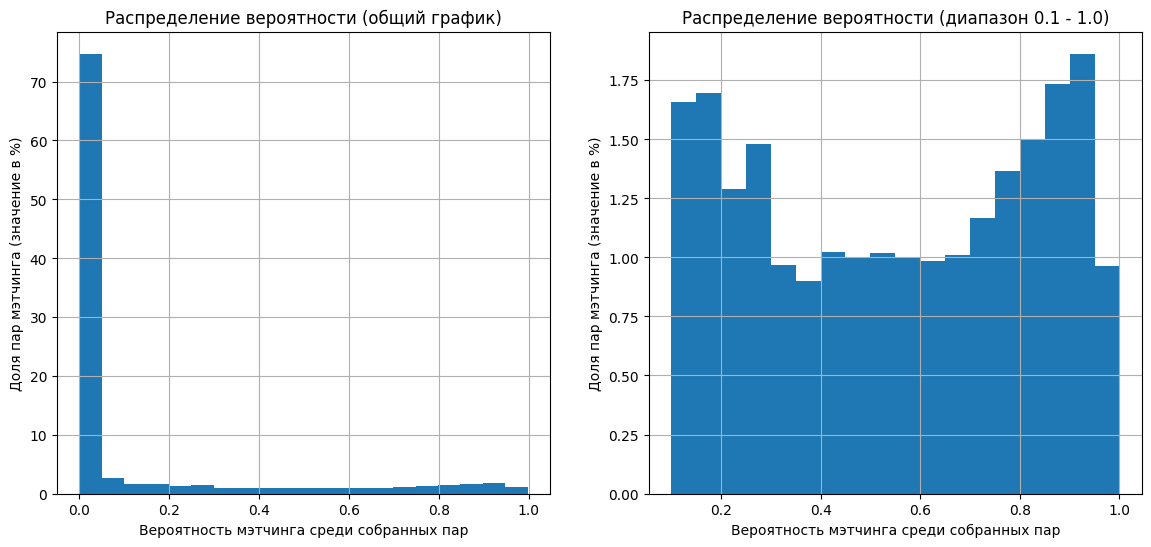

In [6]:
# вероятность мэтчинга
fig, axs = plt.subplots(1, 2, figsize=FIGSIZE)

axs[0].hist(train_df['attrs+title_score'], bins=20, weights=np.ones(len(train_df))/len(train_df)*100)
axs[0].set_title('Распределение вероятности (общий график)')
axs[0].set_ylabel('Доля пар мэтчинга (значение в %)')
axs[0].set_xlabel('Вероятность мэтчинга среди собранных пар')
axs[0].grid()

axs[1].hist(train_df['attrs+title_score'], bins=18, weights=np.ones(len(train_df))/len(train_df)*100, range=(0.1, 1.0))
axs[1].set_title('Распределение вероятности (диапазон 0.1 - 1.0)')
axs[1].set_ylabel('Доля пар мэтчинга (значение в %)')
axs[1].set_xlabel('Вероятность мэтчинга среди собранных пар')
axs[1].grid()
plt.show()

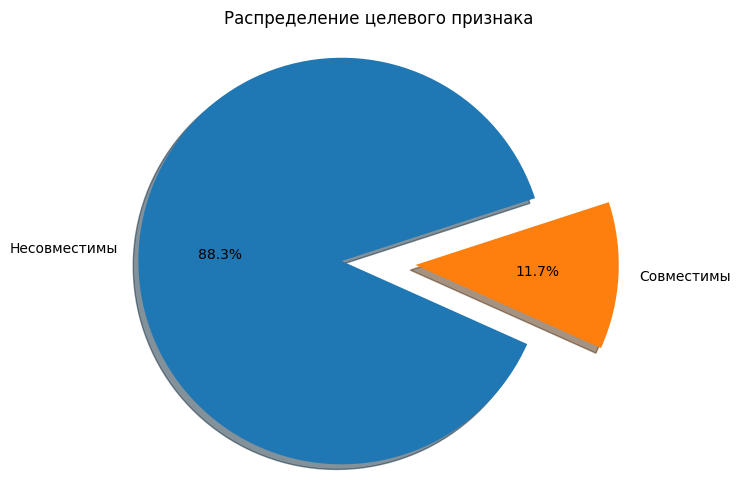

In [7]:
# целевой признак
plt.figure(figsize=FIGSIZE)
plt.pie(train_df['target'].value_counts(),
        labels=['Несовместимы', 'Совместимы'],
        autopct='%1.1f%%',
        startangle=18,
        explode=(0.2, 0.2),
        shadow=True,
        radius=1.10)
plt.title('Распределение целевого признака')
plt.show()

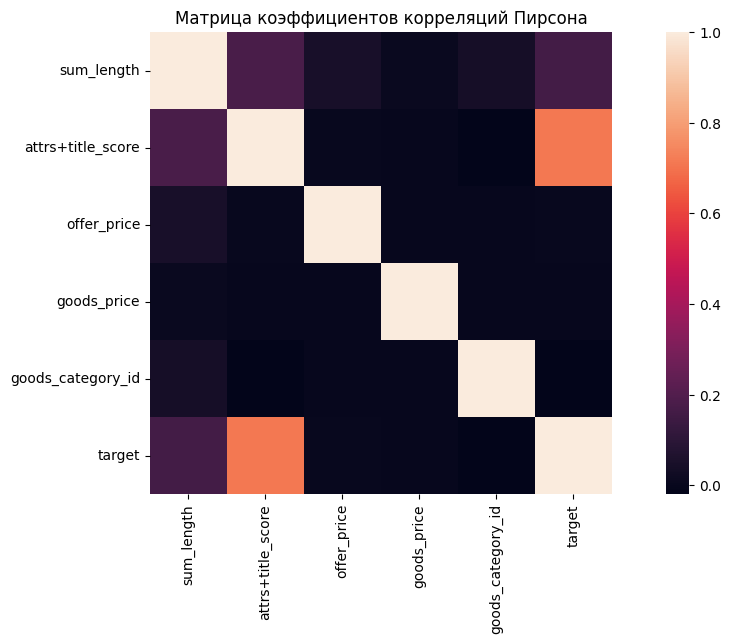

In [8]:
# корреляция Пирсона
plt.figure(figsize=FIGSIZE)
sns.heatmap(train_df.loc[:, 'sum_length':'target'].corr(), square=True)
plt.title('Матрица коэффициентов корреляций Пирсона');

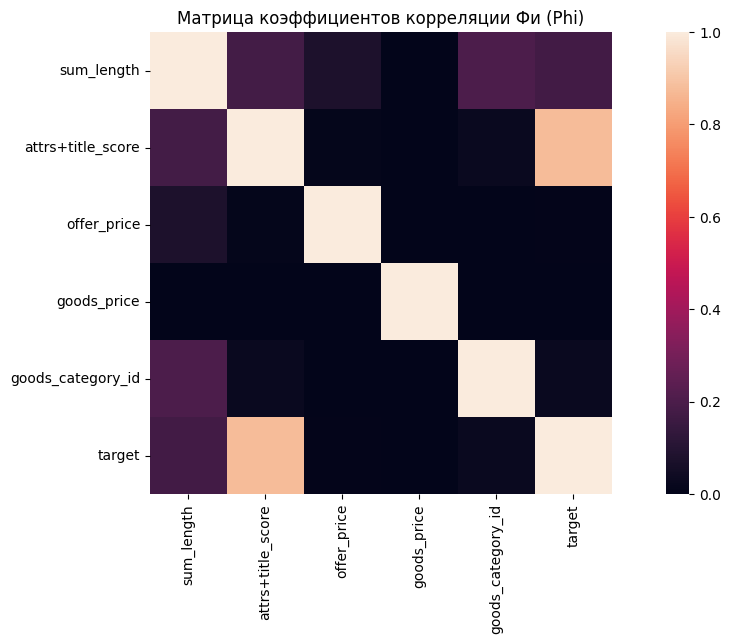

In [9]:
# корреляции Фи
num_columns = ['sum_length', 'attrs+title_score', 'offer_price', 'goods_price', 'goods_category_id', 'target']
phik_matrix = train_df[num_columns].phik_matrix(interval_cols=num_columns)
plt.figure(figsize=FIGSIZE)
sns.heatmap(phik_matrix, square=True)
plt.title('Матрица коэффициентов корреляции Фи (Phi)')
plt.show()

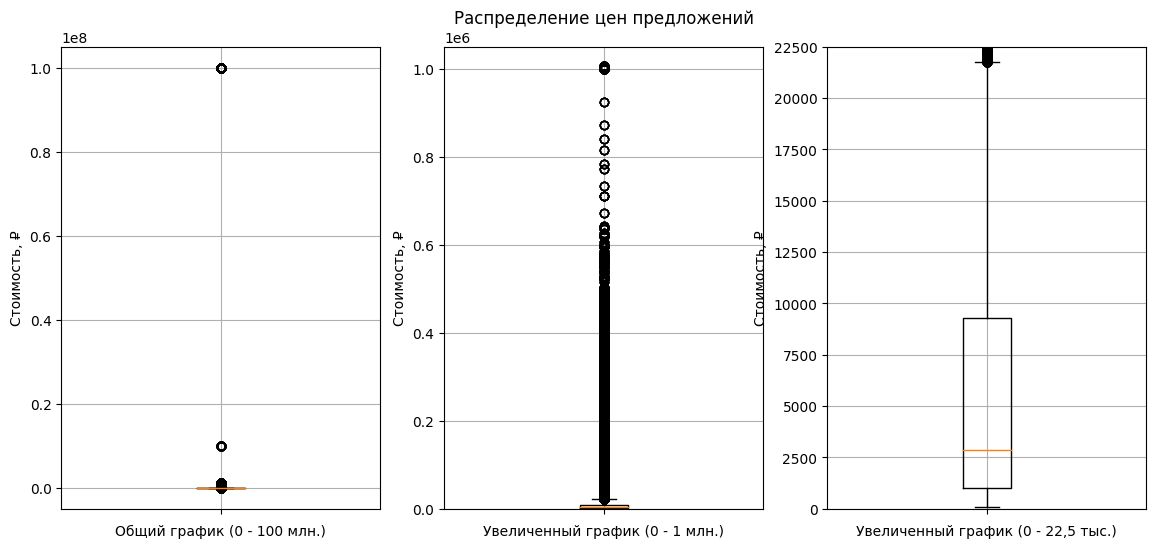

,goods_price
count,2.111154e+06
mean,4.798429e+04
std,7.939302e+06
min,1.010000e+02
25%,6.650000e+02
50%,1.780000e+03
75%,6.516000e+03
max,2.106021e+09


In [10]:
# цены предложений
fig, axs = plt.subplots(1, 3, figsize=FIGSIZE)

axs[0].boxplot(train_df['offer_price'], labels=[''])
axs[0].set_xlabel('Общий график (0 - 100 млн.)')
axs[0].set_ylabel('Стоимость, ₽')
axs[0].grid()

axs[1].boxplot(train_df['offer_price'], labels=[''])
axs[1].set_title('Распределение цен предложений')
axs[1].set_xlabel('Увеличенный график (0 - 1 млн.)')
axs[1].set_ylabel('Стоимость, ₽')
axs[1].set_ylim(0, 1050000)
axs[1].grid()

axs[2].boxplot(train_df['offer_price'], labels=[''])
axs[2].set_xlabel('Увеличенный график (0 - 22,5 тыс.)')
axs[2].set_ylabel('Стоимость, ₽')
axs[2].set_ylim(0, 22500)
axs[2].grid()
plt.show()

display(train_df['goods_price'].describe().to_frame())

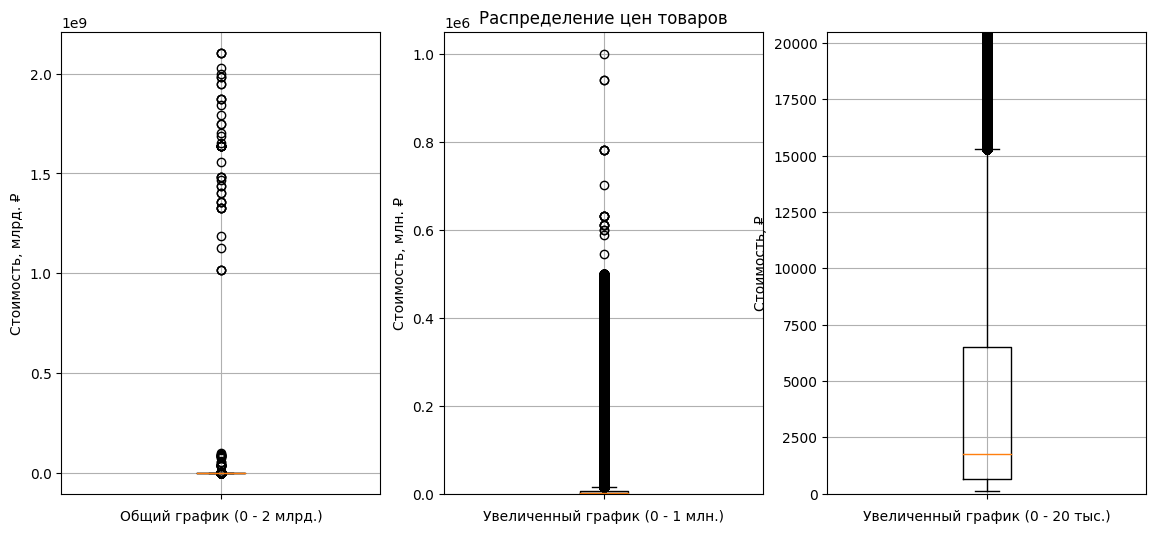

,goods_price
count,2.111154e+06
mean,4.798429e+04
std,7.939302e+06
min,1.010000e+02
25%,6.650000e+02
50%,1.780000e+03
75%,6.516000e+03
max,2.106021e+09


In [11]:
# цены товаров
fig, axs = plt.subplots(1, 3, figsize=FIGSIZE)

axs[0].boxplot(train_df['goods_price'].dropna(), labels=[''])
axs[0].set_xlabel('Общий график (0 - 2 млрд.)')
axs[0].set_ylabel('Стоимость, млрд. ₽')
axs[0].grid()

axs[1].boxplot(train_df['goods_price'].dropna(), labels=[''])
axs[1].set_title('Распределение цен товаров')
axs[1].set_xlabel('Увеличенный график (0 - 1 млн.)')
axs[1].set_ylabel('Стоимость, млн. ₽')
axs[1].set_ylim(0, 1050000)
axs[1].grid()

axs[2].boxplot(train_df['goods_price'].dropna(), labels=[''])
axs[2].set_xlabel('Увеличенный график (0 - 20 тыс.)')
axs[2].set_ylabel('Стоимость, ₽')
axs[2].set_ylim(0, 20500)
axs[2].grid()
plt.show()

display(train_df['goods_price'].describe().to_frame())

ID категорий: [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 11.0, 13.0, 14.0, 17.0, 18.0, 19.0, 21.0, 69.0, 81.0, 82.0, 83.0, 2463684633817211.0, nan]
Кол-во категорий: 21


,count
goods_category_id,
5.000000e+00,460420
6.000000e+00,312857
2.000000e+00,249113
3.000000e+00,195435
1.400000e+01,154753
8.000000e+00,153579
7.000000e+00,150662
8.300000e+01,142425
1.100000e+01,104619


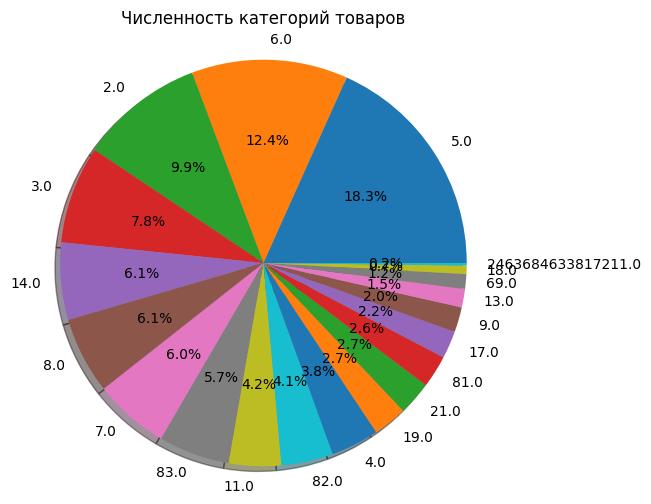

In [12]:
# категории товаров
print('ID категорий:', sorted(list(train_df['goods_category_id'].unique())))
print('Кол-во категорий:', len(train_df['goods_category_id'].unique()))
display(train_df['goods_category_id'].value_counts().to_frame())

plt.figure(figsize=FIGSIZE)
train_df['goods_category_id'].value_counts().plot(kind='pie', autopct='%1.1f%%', shadow=True, radius=1.10, ylabel='')
plt.title('Численность категорий товаров')
plt.show()

Промежуточный вывод:

- Всего около 2,5 млн пар для мэтча.
- Около 18 тыс. пар дублируются.
- Приблизительно на 75% пар для мэтчинга приходится нулевая вероятность. А с учётом колонки `target` 85% пар - несовместимы, лишь 15% пар соотносятся друг с другом. Классы имеют сильный дисбаланс.
- Существует явно выраженная линейная зависимость между `attrs+title_score` и `target`
- Присутствуют выбросы в `offer_price` и `goods_price`
- Пропуски присутствуют лишь в столбцах `goods_price` и `goods_category_id`.
- Категорий товаров - небольшое количество. Все они обозначены условными номерами. Поскольку это целые числа, то тип данных уместно заменить на `Int64`, по при попытке выполнить это возникает ошибка: "boolean value of NA is ambiguous". Особый интерес вызывает категория _№2463684633817211_. Номер особо выделяется на фоне остальных. Это самая малочисленная категория, но тем не менее она содержит почти 5000 товаров.

### Test

In [13]:
# вывод общей информации
display(test_df.head())
test_df.info(verbose=True, show_counts=True)

print('Кол-во мэтчей-дубликатов:', test_df[['offer_depersonalised', 'goods_depersonalised']].duplicated().sum())
print('Кол-во предложений:', len(test_df['offer_depersonalised'].unique()))
print('Кол-во товаров:', len(test_df['goods_depersonalised'].unique()))

,offer_depersonalised,goods_depersonalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,id
0,64819,1396468,38,0.046997,368,NaN,14.0,64819$1396468
1,64819,1396235,38,0.046997,368,NaN,14.0,64819$1396235
2,64819,1396318,38,0.046997,368,NaN,14.0,64819$1396318
3,359959,1396281,40,0.060211,634,NaN,14.0,359959$1396281
4,142700,717657,40,0.000370,14924,31840.0,2.0,142700$717657


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363835 entries, 0 to 363834
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   offer_depersonalised  363835 non-null  int64  
 1   goods_depersonalised  363835 non-null  int64  
 2   sum_length            363835 non-null  int64  
 3   attrs+title_score     363835 non-null  float64
 4   offer_price           363835 non-null  int64  
 5   goods_price           304864 non-null  float64
 6   goods_category_id     363704 non-null  float64
 7   id                    363835 non-null  object 
dtypes: float64(3), int64(4), object(1)
memory usage: 22.2+ MB
Кол-во мэтчей-дубликатов: 0
Кол-во предложений: 72767
Кол-во товаров: 316987


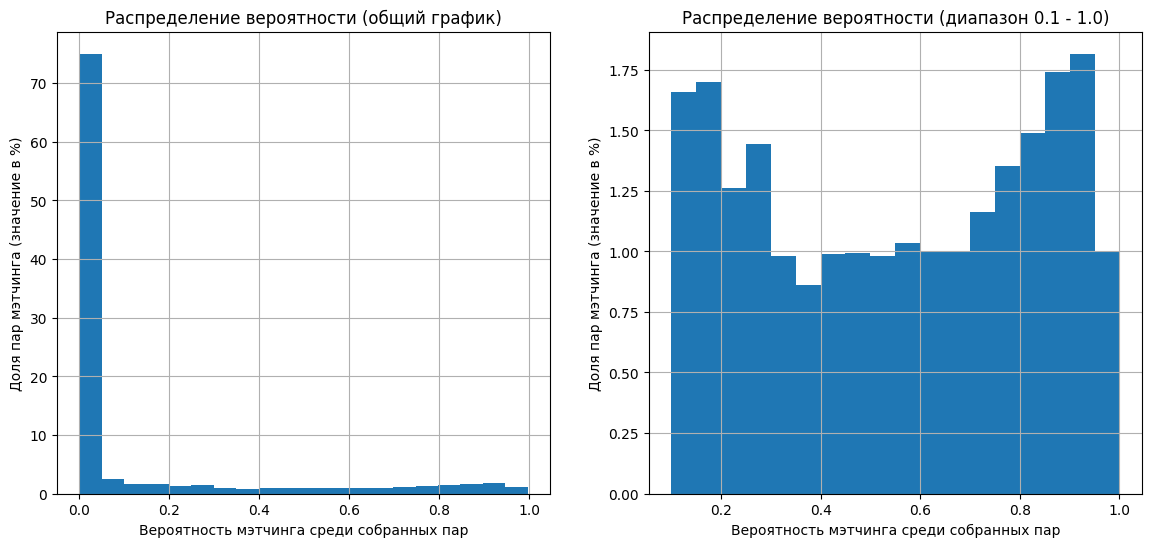

In [14]:
# вероятность матчинга
fig, axs = plt.subplots(1, 2, figsize=FIGSIZE)

axs[0].hist(test_df['attrs+title_score'], bins=20, weights=np.ones(len(test_df))/len(test_df)*100)
axs[0].set_title('Распределение вероятности (общий график)')
axs[0].set_ylabel('Доля пар мэтчинга (значение в %)')
axs[0].set_xlabel('Вероятность мэтчинга среди собранных пар')
axs[0].grid()

axs[1].hist(test_df['attrs+title_score'], bins=18, weights=np.ones(len(test_df))/len(test_df)*100, range=(0.1, 1.0))
axs[1].set_title('Распределение вероятности (диапазон 0.1 - 1.0)')
axs[1].set_ylabel('Доля пар мэтчинга (значение в %)')
axs[1].set_xlabel('Вероятность мэтчинга среди собранных пар')
axs[1].grid()
plt.show()

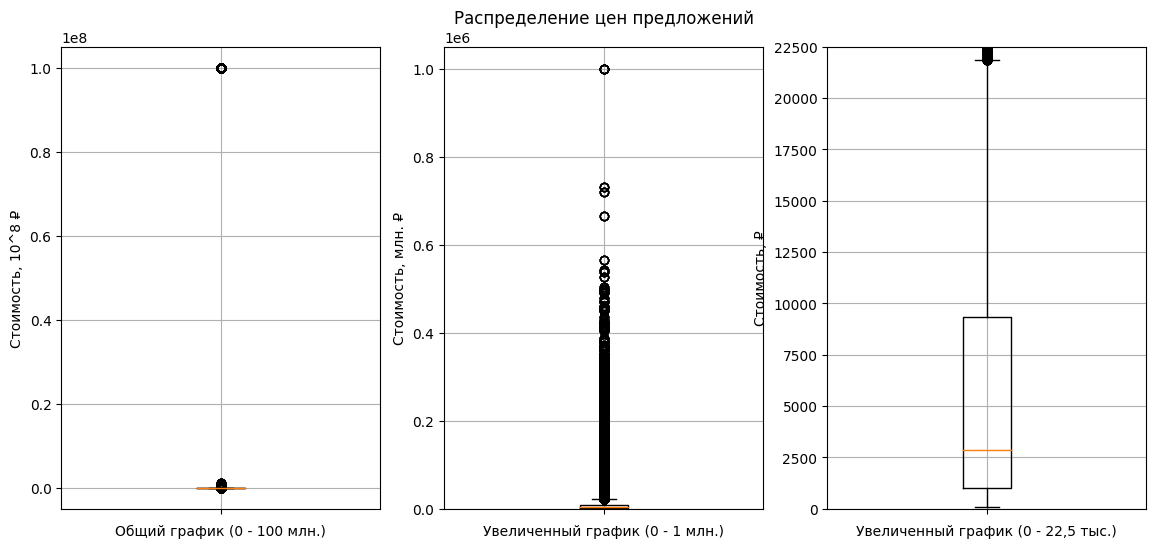

,offer_price
count,3.638350e+05
mean,9.583577e+05
std,9.683426e+06
min,1.010000e+02
25%,9.820000e+02
50%,2.832000e+03
75%,9.321000e+03
max,1.000001e+08


In [15]:
# цены предложений
fig, axs = plt.subplots(1, 3, figsize=FIGSIZE)

axs[0].boxplot(test_df['offer_price'], labels=[''])
axs[0].set_xlabel('Общий график (0 - 100 млн.)')
axs[0].set_ylabel('Стоимость, 10^8 ₽')
axs[0].grid()

axs[1].boxplot(test_df['offer_price'], labels=[''])
axs[1].set_title('Распределение цен предложений')
axs[1].set_xlabel('Увеличенный график (0 - 1 млн.)')
axs[1].set_ylabel('Стоимость, млн. ₽')
axs[1].set_ylim(0, 1050000)
axs[1].grid()

axs[2].boxplot(test_df['offer_price'], labels=[''])
axs[2].set_xlabel('Увеличенный график (0 - 22,5 тыс.)')
axs[2].set_ylabel('Стоимость, ₽')
axs[2].set_ylim(0, 22500)
axs[2].grid()
plt.show()

display(test_df['offer_price'].describe().to_frame())

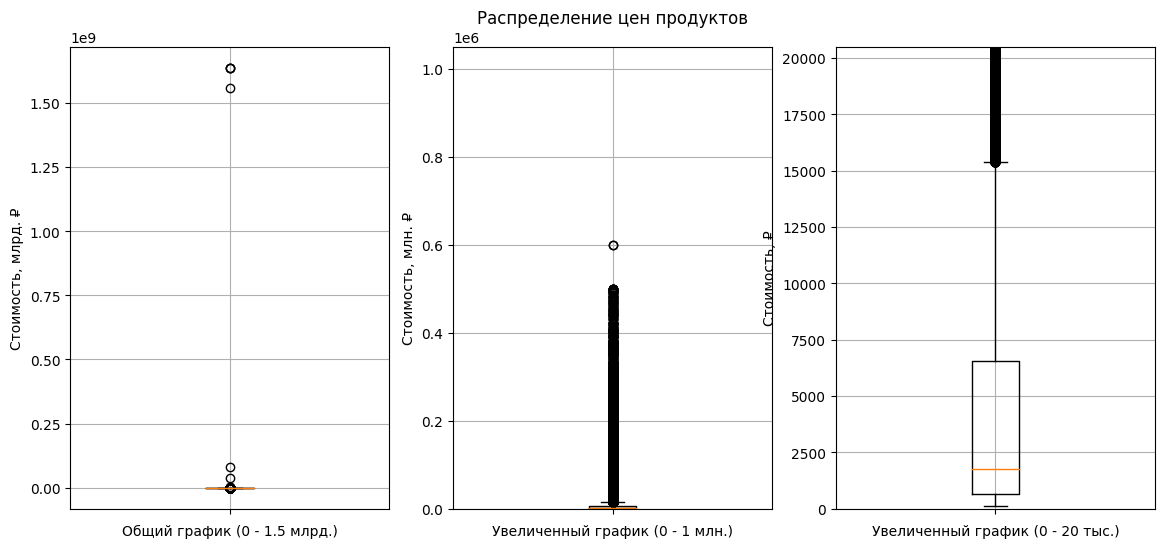

,goods_price
count,3.048640e+05
mean,3.089512e+04
std,5.866152e+06
min,1.010000e+02
25%,6.630000e+02
50%,1.770000e+03
75%,6.550000e+03
max,1.638016e+09


In [16]:
# цены продуктов
fig, axs = plt.subplots(1, 3, figsize=FIGSIZE)

axs[0].boxplot(test_df['goods_price'].dropna(), labels=[''])
axs[0].set_xlabel('Общий график (0 - 1.5 млрд.)')
axs[0].set_ylabel('Стоимость, млрд. ₽')
axs[0].grid()

axs[1].boxplot(test_df['goods_price'].dropna(), labels=[''])
axs[1].set_title('Распределение цен продуктов')
axs[1].set_xlabel('Увеличенный график (0 - 1 млн.)')
axs[1].set_ylabel('Стоимость, млн. ₽')
axs[1].set_ylim(0, 1050000)
axs[1].grid()

axs[2].boxplot(test_df['goods_price'].dropna(), labels=[''])
axs[2].set_xlabel('Увеличенный график (0 - 20 тыс.)')
axs[2].set_ylabel('Стоимость, ₽')
axs[2].set_ylim(0, 20500)
axs[2].grid()
plt.show()

display(test_df['goods_price'].describe().to_frame())

ID категорий: [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 11.0, 13.0, 14.0, 17.0, 18.0, 19.0, 21.0, 69.0, 81.0, 82.0, 83.0, 2463684633817211.0, nan]
Кол-во категорий: 21


,count
goods_category_id,
5.000000e+00,66720
6.000000e+00,45782
2.000000e+00,36526
3.000000e+00,28179
1.400000e+01,22839
8.000000e+00,22193
7.000000e+00,21705
8.300000e+01,20364
1.100000e+01,15450


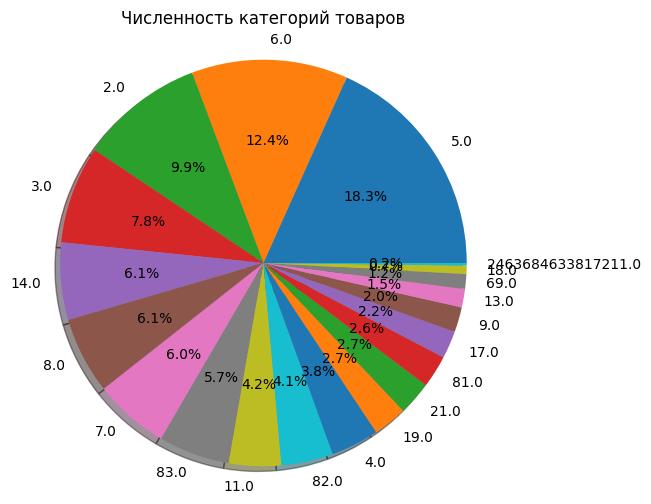

In [17]:
# категории товаров
print('ID категорий:', sorted(list(test_df['goods_category_id'].unique())))
print('Кол-во категорий:', len(test_df['goods_category_id'].unique()))
display(test_df['goods_category_id'].value_counts().to_frame())

plt.figure(figsize=FIGSIZE)
train_df['goods_category_id'].value_counts().plot(kind='pie', autopct='%1.1f%%', shadow=True, radius=1.10, ylabel='')
plt.title('Численность категорий товаров')
plt.show()

Промежуточный вывод:

- Всего около 363 тыс. пар для мэтча.
- Если ориентироваться на распределение вероятности в колонке `attrs+title_score`, то соотношение классов в тренировочной и тестовой выборках идентичны.
- Так же присутствуют выбросы в `offer_price` и `goods_price`
- Пропуски присутствуют в тех же столбцах: `goods_price` и `goods_category_id`.
- Количество категорий товаров - то же количество: 21. И тот же перечень, что и в `train_df`. В том же виде сохранилось распределение товаров по этим категориям.


### Набор данных **товаров** (goods image & title)

Напомню, что датасет содержит в первую очередь id товаров и предложений. А данные, которые могут их охарактеризовать содержатся в отдельных маборах данных формата `.npy`.

Пример векторизованных данных:
 [[ 1.1158133   1.9842914   0.5167014  ... -0.69889563  0.11544477
  -3.1679373 ]
 [ 0.99327075  1.9756604   0.23954017 ...  0.00989665  0.49230903
  -3.0051124 ]
 [-0.36902365 -2.316401    1.3042173  ... -1.6195703   0.7884472
  -2.6850224 ]
 ...
 [-0.16678151 -0.6597981  -0.9382939  ...  0.3883793  -0.21414155
   0.41041985]
 [-0.16678151 -0.6597981  -0.9382939  ...  0.3883793  -0.21414155
   0.41041985]
 [-0.16678151 -0.6597981  -0.9382939  ...  0.3883793  -0.21414155
   0.41041985]]
Размер массива: (317707, 256)
Макс. значение массива: 9.318618
Мин. значение массива: -10.725204

Пример массива индексов:
 ['37' '39' '49' ... '1749527' '1749528' '1749541']
Размер массива: (317707,)


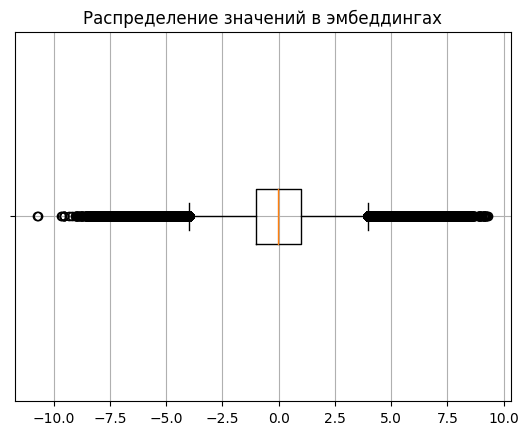

In [29]:
# эмбеддинги изображений товаров
embed_info(goods_image_embed, goods_image_items)

Пример векторизованного изображения:
 [[-0.1097    -0.03256   -0.1995    ...  0.0008154  0.01423   -0.0924   ]
 [ 0.05478    0.0456     0.086     ...  0.04526   -0.0991     0.0728   ]
 [ 0.1026    -0.05792   -0.01443   ...  0.02373    0.1375     0.03757  ]
 ...
 [-0.1048     0.02689    0.05493   ... -0.02917    0.1359    -0.02756  ]
 [ 0.03458    0.12256    0.08636   ...  0.02022   -0.01162   -0.11     ]
 [ 0.09845    0.099     -0.0207    ...  0.03278    0.0746    -0.04443  ]]
Размер массива: (1760568, 64)
Макс. значение массива: 0.3892
Мин. значение массива: -0.4036

Пример векторизованного изображения:
 ['0' '1' '2' ... '1760565' '1760566' '1760567']
Размер массива: (1760568,)


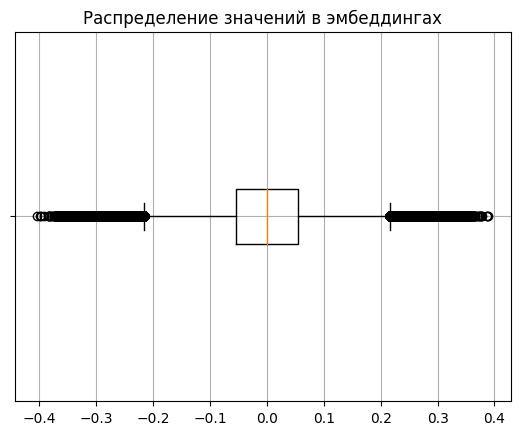

In [26]:
# эмбеддинги названий и атрибутов товаров
embed_info(goods_title_embed, goods_title_items)

Промежуточный вывод:

- 317 тыс. векторизованных изображений. Длинна вектора: 256
- Судя по графику распределения значений, большинство векторов изображений отмасштабированы.
- 1,7 млн. векторизованных названий с атрибутами. Длинна вектора: 64
- аналогичное нормальное распределение значений наблюдается и у векторов текстовой информации
- количество векторов совпадает с количеством items

### Набор данных **предложений** (offer image & title)

Такой же ознакомительный анализ проведу для предложенных товаров.

Пример векторизованных данных:
 [[ 0.31286708  0.9922713   1.2100751  ... -1.7545763  -0.23919716
  -1.2425919 ]
 [ 2.4316337   0.9014603  -0.22259077 ... -1.1001699  -1.1482008
  -0.18731171]
 [ 1.0660228  -0.752132    1.1504172  ...  0.9137148  -0.8000038
  -0.83978504]
 ...
 [ 0.15886657  1.1132201   1.8915755  ... -1.9614205   0.25737146
   2.2726674 ]
 [-0.07633805  1.1760142   1.7563714  ...  0.8059396  -0.01547651
  -1.1802496 ]
 [ 2.2704175  -0.9822532  -0.21690361 ...  1.8719108  -0.7007608
  -1.5808858 ]]
Размер массива: (457586, 256)
Макс. значение массива: 10.499202
Мин. значение массива: -10.556353

Пример массива индексов:
 ['140' '185' '187' ... '572691' '572699' '572735']
Размер массива: (457586,)


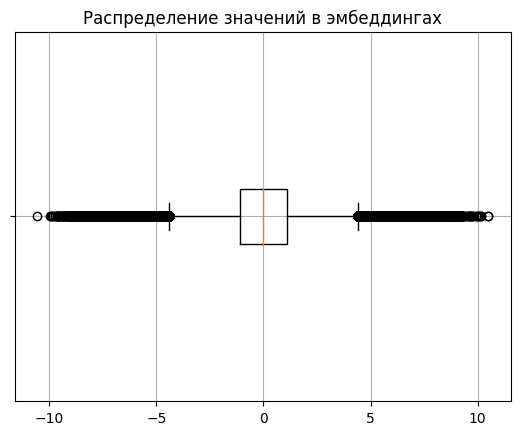

In [30]:
# эмбеддинги изображений предложений
embed_info(offer_image_embed, offer_image_items)

Пример векторизованных данных:
 [[ 0.1005    0.01372   0.02437  ... -0.0833   -0.07996   0.01242 ]
 [-0.0225   -0.2683   -0.06757  ... -0.07855  -0.1098   -0.1461  ]
 [-0.129    -0.0601    0.132    ...  0.0827   -0.01355  -0.1091  ]
 ...
 [ 0.03424   0.1057   -0.1775   ...  0.00539  -0.07495  -0.05234 ]
 [ 0.1133   -0.0424   -0.01152  ...  0.07196  -0.08386  -0.04617 ]
 [ 0.02773   0.012505 -0.02528  ...  0.04718  -0.0552   -0.04034 ]]
Размер массива: (572767, 64)
Макс. значение массива: 0.3806
Мин. значение массива: -0.3906

Пример массива индексов:
 ['477447' '95232' '117886' ... '30926' '209577' '239103']
Размер массива: (572767,)


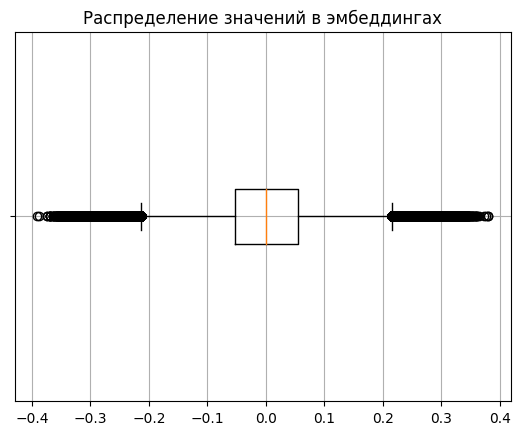

In [31]:
# эмбеддинги названий и атрибутов предложений
embed_info(offer_title_embed, offer_title_items)

Промежуточный вывод:

- 457 тыс. векторизованных изображений. Длинна вектора такая же: 256
- Масштаб значений векторов - аналогичен набору товаров.
- 572 тыс. векторизованных названий с атрибутами. Длинна вектора такая же: 64
- Масштаб значений векторов - такой же
- количество векторов совпадает с количеством items

Для удобной дальнейшей работы, из прочитанных массивов будут сформированы DateFrame, поскольку формат `numpyarray` - это позволяет сделать. После этого все исходные данные будут представлены в одном формате. Это позволит объединять, комбинировать и сравнивать данные между собой.

In [ ]:
# изображение продуктов
goods_image_df = pd.DataFrame(data=goods_image_embed, index=goods_image_items.astype('int'))
display(goods_image_df)

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
37,1.115813,1.984291,0.516701,-0.496422,-0.324674,2.401675,1.017524,-0.508399,0.573803,1.353972,...,-0.180860,0.594790,-1.598920,1.955580,0.400396,1.194853,-0.366639,-0.698896,0.115445,-3.167937
39,0.993271,1.975660,0.239540,-0.717913,-0.751316,2.199577,0.839498,-0.038555,0.410342,1.535055,...,-0.772850,0.609154,-2.114521,2.263286,0.987091,1.511246,-0.285990,0.009897,0.492309,-3.005112
49,-0.369024,-2.316401,1.304217,-0.817354,0.527944,0.424058,-0.406973,2.006788,-0.884583,0.876738,...,-5.050800,-0.737718,3.324481,-2.636603,1.305744,1.034696,-3.347308,-1.619570,0.788447,-2.685022
52,-2.636594,-0.047937,-1.139008,-0.419493,-1.188025,1.555060,-0.790888,1.427739,-2.264456,-2.133656,...,0.148663,-0.235500,0.028043,-0.254297,0.298086,1.297199,0.813299,-0.210692,-2.089919,-2.918503
67,-1.483317,1.117532,-1.183552,-0.696692,-0.993612,1.294827,-2.106248,0.961212,1.336760,-0.624600,...,0.078614,0.430301,1.393044,0.016898,0.763260,-0.396747,0.909528,3.023776,-1.375615,1.135198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1749525,-0.166782,-0.659798,-0.938294,0.283284,0.204901,-0.058343,-0.267377,-0.515039,0.482524,-0.083845,...,0.286327,-0.093635,-0.051898,-0.759333,-0.491636,0.032664,0.636416,0.388379,-0.214142,0.410420
1749526,-0.166782,-0.659798,-0.938294,0.283284,0.204901,-0.058343,-0.267377,-0.515039,0.482524,-0.083845,...,0.286327,-0.093635,-0.051898,-0.759333,-0.491636,0.032664,0.636416,0.388379,-0.214142,0.410420
1749527,-0.166782,-0.659798,-0.938294,0.283284,0.204901,-0.058343,-0.267377,-0.515039,0.482524,-0.083845,...,0.286327,-0.093635,-0.051898,-0.759333,-0.491636,0.032664,0.636416,0.388379,-0.214142,0.410420
1749528,-0.166782,-0.659798,-0.938294,0.283284,0.204901,-0.058343,-0.267377,-0.515039,0.482524,-0.083845,...,0.286327,-0.093635,-0.051898,-0.759333,-0.491636,0.032664,0.636416,0.388379,-0.214142,0.410420


In [ ]:
# названия и атрибуты продуктов
goods_title_df = pd.DataFrame(data=goods_title_embed, index=goods_title_items.astype('int'))
display(goods_title_df)

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,-0.109680,-0.032562,-0.199463,0.035004,0.003799,0.134521,-0.064819,-0.073120,-0.005131,-0.162354,...,0.107788,0.078552,0.061401,-0.047516,-0.017242,0.136963,-0.085449,0.000815,0.014229,-0.092407
1,0.054779,0.045593,0.085999,-0.030533,-0.084595,-0.072876,0.145874,-0.084473,0.046692,-0.064270,...,0.057220,-0.077637,0.031067,0.033691,-0.102173,0.057465,-0.036652,0.045258,-0.099121,0.072815
2,0.102600,-0.057922,-0.014427,-0.018524,-0.029694,0.106750,0.022720,0.046661,-0.111755,0.033417,...,0.091797,-0.006828,0.164551,0.076721,0.116211,0.017059,-0.080322,0.023727,0.137451,0.037567
3,-0.048004,-0.044464,-0.088684,-0.059753,-0.121338,-0.120728,-0.057922,-0.073608,0.002689,0.029129,...,-0.033752,0.156738,0.061005,-0.014679,-0.025574,0.090759,0.015945,-0.045868,0.096069,-0.037323
4,-0.039825,-0.001688,-0.117676,-0.086487,-0.080139,0.068359,-0.024521,-0.108521,-0.049652,-0.090637,...,0.062561,0.070251,-0.012901,-0.053528,0.038666,0.166138,-0.088318,0.059509,-0.004223,-0.115845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1760563,-0.000566,0.114319,-0.023438,0.114746,-0.015327,0.103882,0.011986,0.043060,0.028259,-0.064148,...,0.016876,0.001288,-0.014076,0.058197,-0.086731,-0.116394,0.042572,0.097290,-0.045074,0.067200
1760564,0.078308,0.147827,0.011032,-0.034363,-0.053223,-0.078430,0.089783,-0.092285,0.086243,0.028351,...,0.055939,-0.115417,0.010445,0.054596,-0.058746,0.029617,0.042175,0.095886,-0.155273,0.111755
1760565,-0.104797,0.026886,0.054932,-0.182495,0.077576,0.088562,0.035522,0.107971,0.160278,0.064880,...,0.106018,-0.003666,0.010536,-0.061218,-0.066833,0.078003,0.050232,-0.029175,0.135864,-0.027557
1760566,0.034576,0.122559,0.086365,0.070312,0.105896,-0.176025,-0.040283,0.018555,-0.116150,-0.038849,...,0.004520,0.023270,0.104187,-0.057587,0.008522,0.011139,-0.040833,0.020218,-0.011620,-0.109985


In [ ]:
# изображения предложений
offer_image_df = pd.DataFrame(data=offer_image_embed, index=offer_image_items.astype('int'))
display(offer_image_df)

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
140,0.312867,0.992271,1.210075,0.054043,1.743140,1.437603,0.429724,0.164913,-2.897545,0.769052,...,-0.767819,-0.856839,3.876075,-1.794496,3.168465,2.583651,-2.565749,-1.754576,-0.239197,-1.242592
185,2.431634,0.901460,-0.222591,1.652597,-1.374439,1.629894,-1.035077,0.977082,1.767786,-1.144041,...,-0.744773,3.445973,2.308136,-1.040053,1.265779,-2.920640,0.449690,-1.100170,-1.148201,-0.187312
187,1.066023,-0.752132,1.150417,2.333568,-1.240572,-1.867461,2.284685,-1.706378,-0.503228,0.860026,...,-0.659107,1.626171,0.743693,-0.027171,1.814262,2.386827,-1.219913,0.913715,-0.800004,-0.839785
206,0.577586,-1.632419,-0.191339,-1.283530,0.780364,0.707524,1.614184,3.229915,0.947956,1.898162,...,-0.790198,0.295640,1.587509,-0.931811,3.958591,1.620236,-2.348016,-0.360770,0.659680,-0.639425
242,-1.360919,-3.313266,-0.676416,-0.733953,-3.666931,3.881617,-1.065759,-0.317906,-2.064779,3.542971,...,-2.073461,0.576725,-0.345419,-0.964211,1.700631,3.589146,2.490320,0.687106,2.444057,1.447170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572667,1.857123,1.769553,0.157761,-3.115985,-2.584238,1.625543,-0.203507,2.450319,-3.586230,-4.656075,...,3.239641,-3.409926,1.433778,-1.762236,0.394065,-1.942236,0.567263,-0.992273,0.241363,-0.957638
572681,0.512978,1.962042,2.403048,-2.914190,0.890574,-0.695185,0.356348,1.850505,-0.524562,1.932645,...,2.175135,1.141008,-0.096879,-0.038502,1.310935,0.022356,0.708103,-1.122868,1.261507,-0.231090
572691,0.158867,1.113220,1.891575,0.318891,-1.073635,1.037429,-0.733451,2.803950,-1.367442,-1.367885,...,-0.954234,-1.580596,1.610009,-0.273198,1.941588,-1.002106,-0.118255,-1.961421,0.257371,2.272667
572699,-0.076338,1.176014,1.756371,-2.702494,-3.869815,-1.381477,0.754573,2.093536,-0.711793,-1.246283,...,-0.135391,-2.780791,-0.366079,-0.073657,-0.433691,2.000928,1.634558,0.805940,-0.015477,-1.180250


In [ ]:
# названия и атрибуты предложений
offer_title_df = pd.DataFrame(data=offer_title_embed, index=offer_title_items.astype('int'))
display(offer_title_df)

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
477447,0.100525,0.013718,0.024368,-0.056488,-0.067505,-0.107422,0.029984,0.031647,-0.089661,-0.038605,...,-0.078735,-0.006485,0.047974,-0.070312,0.082764,-0.006165,0.168091,-0.083313,-0.079956,0.012421
95232,-0.022507,-0.268311,-0.067566,-0.040192,-0.031021,-0.046143,0.133301,0.106384,-0.092224,-0.027725,...,0.132080,-0.008453,-0.096069,0.018326,-0.100281,-0.153198,-0.021912,-0.078552,-0.109802,-0.146118
117886,-0.129028,-0.060089,0.131958,0.009232,-0.077454,-0.015808,-0.101318,0.055237,-0.005966,0.111328,...,0.080994,-0.024506,0.029648,-0.010521,-0.000416,0.019699,0.032410,0.082703,-0.013550,-0.109070
218467,-0.160645,-0.020462,0.037384,-0.096130,0.000004,0.106567,-0.075500,-0.083557,0.038239,0.078979,...,-0.075623,0.062317,-0.091064,0.105835,-0.053680,-0.058594,-0.208374,0.018951,0.095276,-0.009026
399432,0.094971,0.005981,0.009201,-0.033356,-0.007111,-0.013527,0.043488,0.140259,0.016403,-0.040894,...,0.015488,0.200317,-0.184448,0.059723,0.018509,-0.057800,-0.075195,-0.016342,-0.046661,0.072388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225200,-0.069824,0.048126,0.031891,0.067322,-0.126709,-0.031250,-0.013527,0.109924,0.149170,-0.012276,...,0.047852,-0.020752,0.022781,-0.030746,-0.099976,-0.001567,0.062683,0.026688,0.111572,0.162476
49145,-0.107544,0.034149,0.015625,0.059204,0.096069,0.028152,-0.019608,0.053223,0.063538,0.146729,...,0.068848,0.015450,0.009483,-0.134888,-0.099243,0.052551,-0.137573,0.007320,0.038269,-0.068542
30926,0.034241,0.105713,-0.177490,0.000896,0.063477,-0.088623,0.014549,0.064636,0.017166,-0.081665,...,-0.107605,-0.195068,-0.089661,0.088745,0.075623,-0.070740,0.041321,0.005390,-0.074951,-0.052338
209577,0.113281,-0.042389,-0.011520,-0.021988,-0.097168,0.101135,0.129395,-0.027786,-0.059723,-0.073059,...,-0.090393,-0.049286,-0.042053,0.024017,0.199219,-0.008133,-0.078125,0.071960,-0.083862,-0.046173


In [ ]:
# очистка ОЗУ
del goods_image_embed, goods_image_items
del goods_title_embed, goods_title_items
del offer_image_embed, offer_image_items
del offer_title_embed, offer_title_items

Общий вывод по первичному анализу:

- Обучающий и тестовый датасеты содержат данные в схожем виде. Соотношение между классами, вероятно всего, одинаковое.
- Присутствуют выбросы в `offer_price` и `goods_price`. Причём стоимость предлагаемых товаров выше на несколько порядков. Речь идёт о миллиардах в противовес миллионам.
- Присутствует небольшое кол-во пропусков в `goods_price` и `goods_category_id`.
- Наборы текстовых и картиночных данных отличаются количеством объектов, но размеры векторов, а так же их масштаб - совпадают.
- Для некоторых товаров и предложений существуют две фотографии. Дублирование в названиях и атрибутах не обнаружено

___

## Предобработка данных

Предварительный план:
- обработка пропусков в `goods_price` и `goods_category_id`
- работа с выбросами в `offer_price` и `goods_price`
- обработка дубликатов пар для мэтчинга, а так же графической и текстовой инормации о товарах

### Пропуски

Большое кол-во пропусков в стоимости товаров могут бы обусловлена отсутствие этих товаров в продаже. Актуальную стоимость узнать, увы, не представляется возможным. Хорошим решением было бы оставлять последнюю стоимость. Но это предложение лишь на будущее.

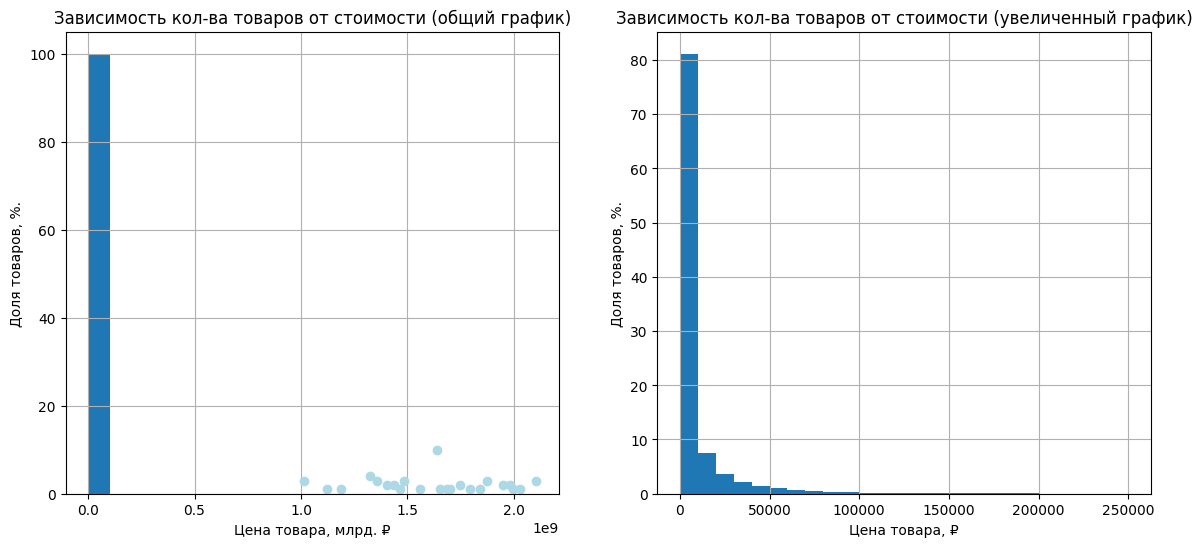

,goods_price
count,2.111154e+06
mean,4.798429e+04
std,7.939302e+06
min,1.010000e+02
25%,6.650000e+02
50%,1.780000e+03
75%,6.516000e+03
max,2.106021e+09


Кол-во пропусков: 407287 (16.17%)


In [ ]:
# пропуски в стоимости товаров
goods_price = train_df.loc[~train_df['goods_price'].isna(), 'goods_price']
fig, axs = plt.subplots(1, 2, figsize=FIGSIZE)

axs[0].hist(goods_price, bins=20, weights=np.ones(len(goods_price))/len(goods_price)*100)
axs[0].plot(goods_price[goods_price > 10**8].value_counts(), marker='o', linestyle='', color='lightblue')
axs[0].set_title('Зависимость кол-ва товаров от стоимости (общий график)')
axs[0].set_ylabel('Доля товаров, %.')
axs[0].set_xlabel('Цена товара, млрд. ₽')
axs[0].grid()

axs[1].hist(goods_price, bins=25, weights=np.ones(len(goods_price))/len(goods_price)*100, range=(0, 250000))
axs[1].set_title('Зависимость кол-ва товаров от стоимости (увеличенный график)')
axs[1].set_ylabel('Доля товаров, %.')
axs[1].set_xlabel('Цена товара, ₽')
axs[1].grid()
plt.show()

display(train_df['goods_price'].describe().to_frame())
print('Кол-во пропусков: {} ({:.2%})'.format(train_df['goods_price'].isna().sum(),
                                             train_df['goods_price'].isna().sum()/len(train_df)))

В текущий момент пропуски следует оставить и использовать ML-модели поддерживающие работу с nan значениями. Либо использовать "заглушку". Взамен пропусков поставить заведомо недопустимую цену: нулевое или отрицательное значение. Такое решение может подойти при использовании модели Логистической регрессии.

Небольшое количество товаров имеют пропуск в их категории. Имея id товаров можно произвести поиск по всем датасетам с целью найти другие строчки матчинга этого же товара, где номер категории не потеряно.

In [ ]:
# пропуски в категориях товаров
print('Кол-во пропусков: {} ({:.2%})'.format(train_df['goods_category_id'].isna().sum(),
                                             train_df['goods_category_id'].isna().sum()/len(train_df)))
print('Результат мэтчинга товаров с пропуском:', train_df.loc[train_df['goods_category_id'].isna(), 'target'].unique())

# поиск товаров с указанным id категории
goods_nan_category = train_df.loc[train_df['goods_category_id'].isna(), 'goods_depersonalised'].unique()
display(train_df[train_df['goods_depersonalised'].isin(goods_nan_category) & ~train_df['goods_category_id'].isna()])
display(test_df[test_df['goods_depersonalised'].isin(goods_nan_category) & ~test_df['goods_category_id'].isna()])

Кол-во пропусков: 833 (0.03%)
Результат мэтчинга товаров с пропуском: [0]


,offer_depersonalised,goods_depersonalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,target,id


,offer_depersonalised,goods_depersonalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,id


На практике таких строчек не оказалось. Все товары с пропуском категории, фактически не присвоены не к одной из них. Так же все эти товары не являются парой для матчинга.

Ввиду небольшого количества таких объектов их можно удалить, если это приведёт к улучшению качества предсказания.

### Выбросы

- работа с выбросами в `offer_price` и `goods_price`

В обучающей выборке присутствуют товары, стоимость которых начинается от 1 млрд рублей. При этом максимальная стоимость предлагаемых товаров на порядок ниже: 100 млн. рублей. Возможно, эти товары вряд ли получится с чем-то сопоставить и получить от них какую либо пользу.

Попробовать ограничиться Q3 + 1,5*IQR или отбросить заведомо высокие значения.

In [ ]:
extremely_high_price = train_df[train_df['goods_price'] >= 10**9].index
display(train_df.loc[extremely_high_price].head(10))
print('Кол-во сверх дорогих товаров:', len(extremely_high_price))
print('Варианты мэтчинга с предложениями:', train_df.loc[extremely_high_price, 'target'].unique())

,offer_depersonalised,goods_depersonalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,target,id
419409,424770,838064,191,0.237915,28180,2.028020e+09,5.0,0,424770$838064
817251,423053,838078,279,0.751953,19760,1.638016e+09,6.0,0,423053$838078
845639,168020,838070,290,0.002199,16324,1.794018e+09,6.0,0,168020$838070
977154,428398,838073,361,0.000037,41140,1.404014e+09,6.0,0,428398$838073
1820633,423355,41040,762,0.000043,26620,1.186012e+09,6.0,0,423355$41040
1829812,436512,41038,768,0.000876,66940,1.638016e+09,6.0,0,436512$41038
1865466,423360,41073,792,0.000296,8010,1.638016e+09,6.0,0,423360$41073
1865467,423359,41073,792,0.000315,8010,1.638016e+09,6.0,0,423359$41073
1868408,427365,41073,794,0.000177,14140,1.638016e+09,6.0,0,427365$41073
1868501,423358,41073,794,0.000227,8010,1.638016e+09,6.0,0,423358$41073


Кол-во сверх дорогих товаров: 50
Варианты мэтчинга с предложениями: [0]


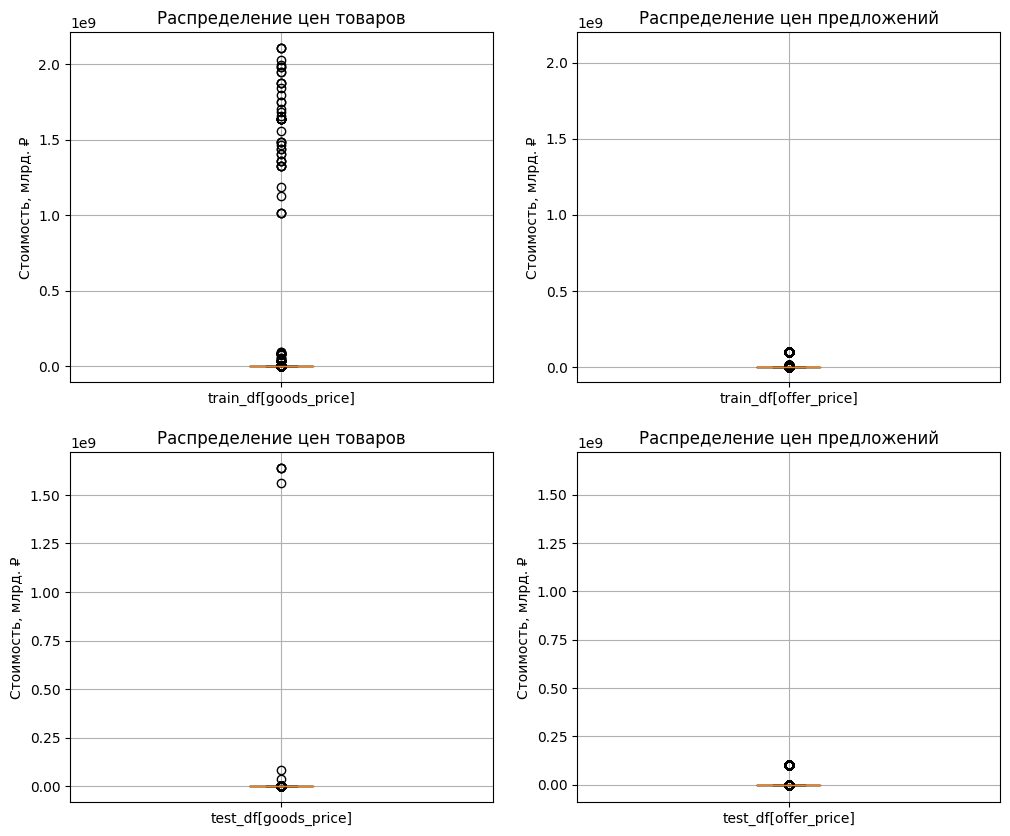

In [ ]:
# распределения цен товаров и предложений
fig, axs = plt.subplots(2, 2, figsize=(12,10))

axs[0,0].boxplot(train_df['goods_price'].dropna(), labels=['train_df[goods_price]'])
axs[0,0].set_title('Распределение цен товаров')
axs[0,0].set_ylabel('Стоимость, млрд. ₽')
axs[0,0].grid()

axs[0,1].boxplot(train_df['offer_price'], labels=['train_df[offer_price]'])
axs[0,1].set_title('Распределение цен предложений')
axs[0,1].set_ylabel('Стоимость, млрд. ₽')
axs[0,1].set_ylim(-100000000, 2200000000)
axs[0,1].grid()

axs[1,0].boxplot(test_df['goods_price'].dropna(), labels=['test_df[goods_price]'])
axs[1,0].set_title('Распределение цен товаров')
axs[1,0].set_ylabel('Стоимость, млрд. ₽')
axs[1,0].grid()

axs[1,1].boxplot(test_df['offer_price'], labels=['test_df[offer_price]'])
axs[1,1].set_title('Распределение цен предложений')
axs[1,1].set_ylabel('Стоимость, млрд. ₽')
axs[1,1].set_ylim(-90000000, 1720000000)
axs[1,1].grid()
plt.show()

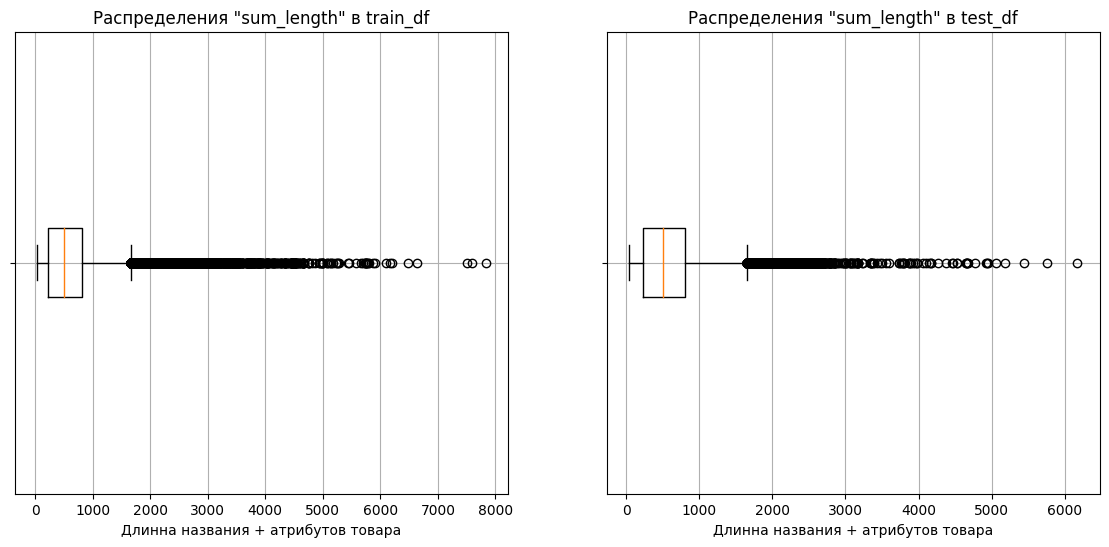

,sum_length_train,sum_length_test
count,2.518441e+06,363835.000000
mean,5.870672e+02,583.423703
std,4.265811e+02,423.870065
min,3.700000e+01,38.000000
25%,2.310000e+02,231.000000
50%,5.070000e+02,504.000000
75%,8.070000e+02,800.000000
max,7.829000e+03,6175.000000


In [ ]:
# распределения длинна названия и атрибутов товара
fig, axs = plt.subplots(1, 2, figsize=FIGSIZE)

axs[0].boxplot(train_df['sum_length'], labels=[''])
axs[0].set_title('Распределения "sum_length" в train_df')
axs[0].set_xlabel('Длинна названия + атрибутов товара')
axs[0].grid(True)

axs[1].boxplot(test_df['sum_length'], labels=[''])
axs[1].set_title('Распределения "sum_length" в test_df')
axs[1].set_xlabel('Длинна названия + атрибутов товара')
axs[1].set_ylim(-50, 8050)
axs[1].grid(True)
plt.show()

train_sum_length = train_df['sum_length'].describe().to_frame()
test_sum_length  = test_df['sum_length'].describe().to_frame()
display(train_sum_length.merge(test_sum_length, left_index=True, right_index=True, suffixes=['_train', '_test']))
high_sum_length = train_df[train_df['sum_length'] <= train_df['sum_length'].quantile(0.99)].index

In [ ]:
# удаление аномально высоких цен
print('Before:', len(train_df))
train_df.drop(extremely_high_price, axis='index', inplace=True)
#train_df.drop(high_sum_length, axis='index', inplace=True)
print('After: ', len(train_df))

Before: 2493211
After:  2493161


### Дубликаты

В датасете `train.csv` присутствует 18441 дублирующая пара товаров для матчинга. Они не имеют различий, кроме категории `goods_category_id`.

Работа заключается в том, чтобы из всего датасета выбрать только те пары, которые дублируются. Они как раз продемонстрированы в примере ниже. Отличаются такие пары как правило только категорией товара (`goods_category_id`). Остальные значения (результат матча и вероятность от рескоринговой модели) - совпадают.

Далее производится группировка дубликатов по id товаров и предложений, а значения в столбце `target` суммируется. В результате должны получится 3 возможных результата после агрегирования:
- `0` - если оба варианта матчинга не возможны
- `1` - если возможен лишь один вариант матчинга
- `2` - если оба варианта матчинга осуществимы.

In [ ]:
# дубликаты товаров для мэтчинга
id_columns = ['offer_depersonalised', 'goods_depersonalised']
display(train_df[train_df.drop(['goods_category_id'], axis=1).duplicated(keep=False)].sort_values(by=id_columns).head(6))

double_columns = ['offer_depersonalised', 'goods_depersonalised', 'target']
double = train_df[train_df[double_columns].duplicated(keep=False)].sort_values(id_columns)
print('Варианты мэтча дубликатов:', double.groupby(id_columns)['target'].sum().unique())

,offer_depersonalised,goods_depersonalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,target,id
2157191,94,1634475,1054,0.003901,976,1086.0,82.0,0,94$1634475
2157192,94,1634475,1054,0.003901,976,1086.0,81.0,0,94$1634475
2335452,94,1710914,1279,0.859375,976,1177.0,82.0,1,94$1710914
2335453,94,1710914,1279,0.859375,976,1177.0,81.0,1,94$1710914
2337861,94,1710947,1283,0.013901,976,1384.0,82.0,0,94$1710947
2337862,94,1710947,1283,0.013901,976,1384.0,81.0,0,94$1710947


Варианты мэтча дубликатов: [0 2]


В результате получается, что абсолютно все дубликаты имеют одинаковый результат по мэтчингу. Вне зависимости от категории товара. По этой причине можно избавиться от дублирования, удалив одну половину записей. Все товары будут иметь один и единственный вариант для мэтчинга.

Но допустим и вариант, при котором дублирующие объекты остаются. Они не вызывают противоречия. Выглядят как альтернативные варианты для сопоставления. К примеру планшет может быть как в одноимённо категории, так и в категории "Компактные ноутбуки", в случае если он комплектуется клавиатурой.

_По результатам некоторых тестов - удаление дубликатов принесло небольшое ухудшение в метрике F1._

In [ ]:
# удаление дубликатов мэтча
'''
before = train_df.shape[0]
train_df.drop_duplicates(double_columns, inplace=True)
after = train_df.shape[0]

print('Before:', before)
print('After: ', after)
print('Diff:  ', before - after)
'''

В исходных массивах эмбеддингов фотографий содержатся неявные дубликаты для товаров и предложений (несколько фотографий одного и того же объекта). Ниже они будут явно продемонстрированы. Удаление дубликатов не принесло явно положительного результата: на валидации метрика увеличилась, на тесте уменьшилась.

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
320,0.028976,0.730363,-1.281051,-0.100079,0.855477,2.162303,-2.450919,1.304461,0.087957,-0.561346,...,1.835589,-1.189534,-1.187329,-0.618400,-0.037176,1.723567,-0.323196,1.112901,-0.748570,0.829919
320,-1.649838,0.950786,-1.109396,0.253702,1.264648,1.496626,-1.511482,1.257492,-0.700077,-0.266071,...,0.818846,-0.181633,-2.420810,0.169975,0.404856,1.722667,-1.941895,-0.020341,1.403384,1.664825
321,-2.205180,1.248743,-1.627445,-0.877083,-0.041798,0.229910,-0.592625,2.179549,-0.265969,0.647153,...,0.282920,-1.185048,-2.767393,0.085783,-0.363956,0.810407,-1.261354,0.128255,1.922604,0.193719
321,-2.108333,1.303601,-1.656884,-0.850636,-0.141474,0.052352,-0.646520,2.422256,-0.456114,0.296800,...,0.354792,-1.239907,-2.861247,-0.110674,-0.786232,1.087877,-1.495511,0.324001,2.232999,-0.202618
587,0.109655,2.055944,1.368361,-0.238393,-0.661528,1.181042,0.273196,-0.596125,-2.899017,2.444120,...,0.184842,0.627262,0.278968,1.413151,2.997869,2.299328,1.381709,-0.504156,-1.255474,2.144972
587,2.037811,0.896891,-0.598309,-0.135401,0.413046,1.910169,1.921181,-1.345852,0.646819,0.923702,...,0.368236,1.067453,0.451685,0.354544,3.700801,-0.766567,0.678616,-2.663189,-0.197439,1.540558


Кол-во дублирующих фотографий: 5153
Before: 317707
After:  317707


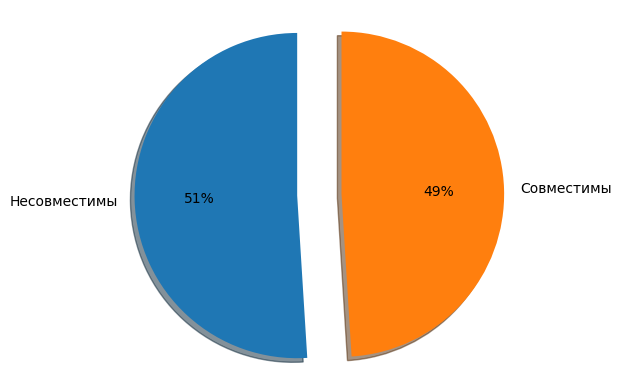

In [ ]:
# неявные дубликаты фотографий товаров
display(goods_image_df[goods_image_df.index.duplicated(keep=False)].sort_index().head(6))
print('Кол-во дублирующих фотографий:', len(goods_image_df[goods_image_df.index.duplicated()]))

goods_duples = goods_image_df[goods_image_df.index.duplicated()].index
train_df.loc[train_df['goods_depersonalised'].isin(goods_duples), 'target'].value_counts().plot(kind='pie',
        labels=['Несовместимы', 'Совместимы'],
        autopct='%1.0f%%',
        startangle=90,
        explode=(0.3, 0),
        shadow=True,
        radius=1.10,
        ylabel='');

print('Before:', goods_image_df.shape[0])
#goods_image_df = goods_image_df[~goods_image_df.index.duplicated()]
print('After: ', goods_image_df.shape[0])

In [ ]:
# неявные дубликаты среди фотографий предложений
display(offer_image_df[offer_image_df.index.duplicated(keep=False)].sort_index().head(6))
print('Кол-во дублирующих фотографий:', len(offer_image_df[offer_image_df.index.duplicated()]))

print('Before:', offer_image_df.shape[0])
#offer_image_df = offer_image_df[~offer_image_df.index.duplicated()]
print('After: ', offer_image_df.shape[0])

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
112384,0.248492,-0.112064,-0.051028,0.362538,-2.320066,1.618862,0.316475,0.882098,-0.642882,1.599373,...,-2.473495,0.122219,0.442962,-0.304895,-0.294796,-0.976742,-0.691276,0.142763,1.295351,-3.644961
112384,0.986717,0.013103,1.084765,-0.496662,-0.914949,0.215318,-0.066401,4.728871,0.048007,0.397275,...,-1.339353,-0.740521,-0.119125,0.679045,-1.033394,1.820760,-1.472917,-0.174956,-0.152096,-1.553125


Кол-во дублирующих фотографий: 1
Before: 457586
After:  457586


Промежуточный вывод: Все дефекты выявлены. По результатам тестов, датасет стоит оставить в исходном виде.

___

## EDA

Предварительный план:
- анализ текстовой и графической информации из массивов `.npy`
- анализ выбросов в `offer_price` и `goods_price` (аномалия или нет?)
- корреляция в эмбеддингах

### Анализ выбросов в `offer_price` и `goods_price`

### Корреляция в эмбеддингах

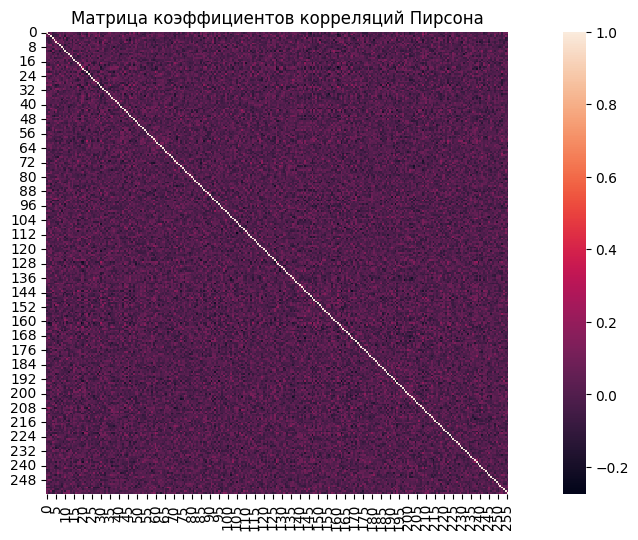

In [ ]:
# корреляция Пирсона
plt.figure(figsize=FIGSIZE)
sns.heatmap(goods_image_df.corr(), square=True)
plt.title('Матрица коэффициентов корреляций Пирсона');

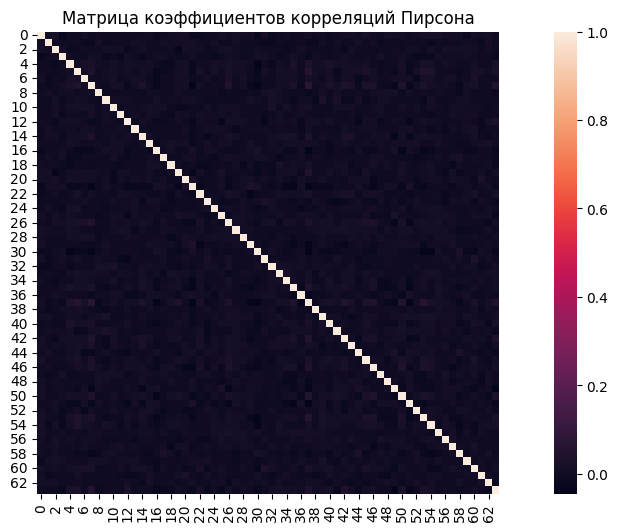

In [ ]:
# корреляция Пирсона
plt.figure(figsize=FIGSIZE)
sns.heatmap(goods_title_df.corr(), square=True)
plt.title('Матрица коэффициентов корреляций Пирсона');

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>,
        <Axes: title={'center': '2'}>, <Axes: title={'center': '3'}>,
        <Axes: title={'center': '4'}>, <Axes: title={'center': '5'}>,
        <Axes: title={'center': '6'}>, <Axes: title={'center': '7'}>],
       [<Axes: title={'center': '8'}>, <Axes: title={'center': '9'}>,
        <Axes: title={'center': '10'}>, <Axes: title={'center': '11'}>,
        <Axes: title={'center': '12'}>, <Axes: title={'center': '13'}>,
        <Axes: title={'center': '14'}>, <Axes: title={'center': '15'}>],
       [<Axes: title={'center': '16'}>, <Axes: title={'center': '17'}>,
        <Axes: title={'center': '18'}>, <Axes: title={'center': '19'}>,
        <Axes: title={'center': '20'}>, <Axes: title={'center': '21'}>,
        <Axes: title={'center': '22'}>, <Axes: title={'center': '23'}>],
       [<Axes: title={'center': '24'}>, <Axes: title={'center': '25'}>,
        <Axes: title={'center': '26'}>, <Axes: title={'center': '27'}>,

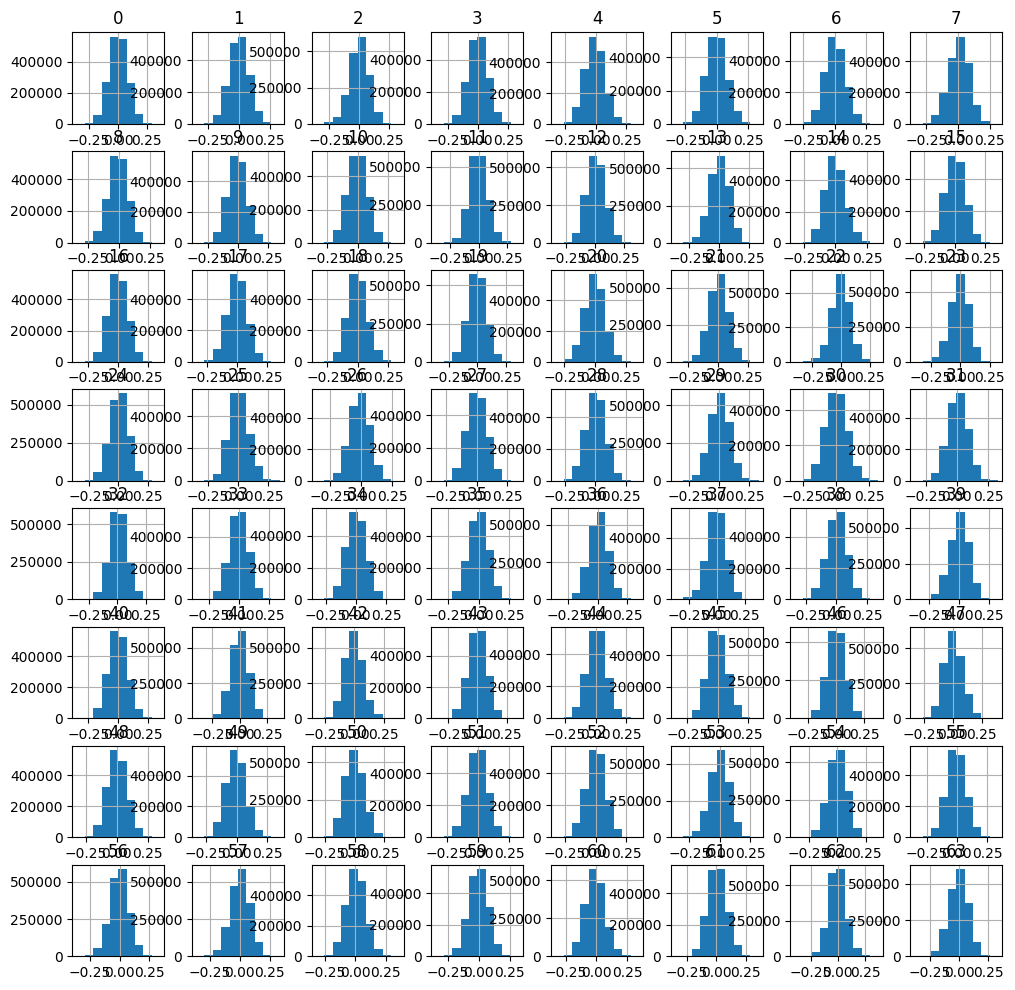

In [ ]:
goods_title_df.hist(figsize=(12, 12))

### Анализ категории товаров

In [ ]:
display(train_df[train_df['goods_category_id']==2463684633817211])
print('Результаты мэтчинга в выборке:', train_df.loc[train_df['goods_category_id']==2463684633817211, 'target'].unique())


,offer_depersonalised,goods_depersonalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,target,id
6921,17567,852283,69,0.000035,2199,NaN,2.463685e+15,0,17567$852283
40785,252733,794808,92,0.000704,310,NaN,2.463685e+15,0,252733$794808
41298,132974,1219444,92,0.000034,37100,950.0,2.463685e+15,0,132974$1219444
47217,86958,301717,95,0.000551,384,609.0,2.463685e+15,0,86958$301717
65684,155387,1357660,105,0.000033,3203,NaN,2.463685e+15,0,155387$1357660
...,...,...,...,...,...,...,...,...,...
2518436,464047,130193,6486,0.000057,559,NaN,2.463685e+15,0,464047$130193
2518437,464047,209576,6632,0.000043,559,692.0,2.463685e+15,0,464047$209576
2518438,4579,1163344,7503,0.000105,667,290.0,2.463685e+15,0,4579$1163344
2518439,340842,1163356,7597,0.000134,717,313.0,2.463685e+15,0,340842$1163356


Результаты мэтчинга в выборке: [0]


In [ ]:
test_df[(test_df['goods_category_id']==2463684633817211)]

,offer_depersonalised,goods_depersonalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,id
991,87051,794791,70,0.000385,304,NaN,2.463685e+15,87051$794791
1103,87051,794794,71,0.005386,304,NaN,2.463685e+15,87051$794794
10472,523942,505168,108,0.000092,1889,NaN,2.463685e+15,523942$505168
10545,143251,1357660,108,0.000036,21449,NaN,2.463685e+15,143251$1357660
11894,469449,713519,112,0.001121,793,425.0,2.463685e+15,469449$713519
...,...,...,...,...,...,...,...,...
363830,122775,310950,5061,0.000036,804,NaN,2.463685e+15,122775$310950
363831,419632,342465,5184,0.000092,332,184.0,2.463685e+15,419632$342465
363832,369393,130129,5447,0.000267,660,614.0,2.463685e+15,369393$130129
363833,24514,130142,5760,0.001467,2000,259.0,2.463685e+15,24514$130142


Промежуточный вывод:

- Необычная категория товара по факту не несёт никакого негативного результата. Все товары из этой категории не мэтчатся с предложениями. Модели машинного обучения абсолютно верно классифицируют эти пары. Эта категория могла стать верным признаком несовместимости товаров.

## Создание выборки данных для ML

Предварительный план:
- создать датафреймы из npy-массивов с текстовой и графической информацией
- дополнить `train_df` характеристиками о товарах и предложениях
- проверить слияние `train_df` и эмбеддингов
- выделить валидационную выборку из обучающей
- проверить качество выполнение стратификации

Расшифровка суффиксов:
- `_gi` - _goods_image_
- `_gt` - _goods_title_
- `_oi` - _offer_image_
- `_ot` - _offer_title_

In [ ]:
train_XY = train_df.drop('id', axis='columns').copy()
train_XY = train_XY.merge(goods_image_df, left_on='goods_depersonalised', right_index=True, how='left')
train_XY = train_XY.merge(offer_image_df, left_on='offer_depersonalised', right_index=True, how='left', suffixes=('_gi',
                                                                                                                  '_oi'))
train_XY = train_XY.merge(goods_title_df, left_on='goods_depersonalised', right_index=True, how='left')
train_XY = train_XY.merge(offer_title_df, left_on='offer_depersonalised', right_index=True, how='left', suffixes=('_gt',
                                                                                                                  '_ot'))

train_XY.reset_index(drop=True, inplace=True)
display(train_XY)

,offer_depersonalised,goods_depersonalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,target,0_gi,1_gi,...,54_ot,55_ot,56_ot,57_ot,58_ot,59_ot,60_ot,61_ot,62_ot,63_ot
0,295140,1396793,37,0.027267,1070,NaN,1.400000e+01,0,NaN,NaN,...,-0.139893,0.070007,0.014290,-0.018616,-0.008324,-0.084534,0.016281,0.028748,-0.062378,-0.202515
1,65291,1396586,38,0.050415,698,NaN,1.400000e+01,0,NaN,NaN,...,-0.026657,0.017883,0.006878,-0.037598,-0.052673,0.000644,-0.150024,0.075623,0.038727,-0.048004
2,39232,1396244,38,0.087280,837,NaN,1.400000e+01,0,NaN,NaN,...,-0.149780,0.038483,0.021423,-0.062561,0.039154,0.028320,-0.053375,0.060211,0.041931,0.024948
3,39232,1396513,38,0.087280,837,NaN,1.400000e+01,0,NaN,NaN,...,-0.149780,0.038483,0.021423,-0.062561,0.039154,0.028320,-0.053375,0.060211,0.041931,0.024948
4,65052,1396237,38,0.079773,1085,NaN,1.400000e+01,0,NaN,NaN,...,-0.135254,0.074280,0.014252,-0.015068,-0.008812,-0.077332,0.026855,0.014427,-0.064026,-0.207764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2528959,464047,130193,6486,0.000057,559,NaN,2.463685e+15,0,NaN,NaN,...,0.052185,-0.018326,-0.048218,0.052216,0.010368,-0.058716,-0.053253,-0.015076,-0.129517,-0.021591
2528960,464047,209576,6632,0.000043,559,692.0,2.463685e+15,0,NaN,NaN,...,0.052185,-0.018326,-0.048218,0.052216,0.010368,-0.058716,-0.053253,-0.015076,-0.129517,-0.021591
2528961,4579,1163344,7503,0.000105,667,290.0,2.463685e+15,0,NaN,NaN,...,0.011368,0.093201,-0.011780,-0.055542,-0.102966,0.067932,0.096069,-0.079346,-0.132446,0.118042
2528962,340842,1163356,7597,0.000134,717,313.0,2.463685e+15,0,NaN,NaN,...,0.006447,-0.062103,-0.026703,-0.020050,-0.070923,0.040283,0.023819,0.019684,0.078857,0.090393


In [ ]:
# очистка ОЗУ
'''
del goods_image_df
del goods_title_df
del offer_image_df
del offer_title_df
'''

### Feature engineering

In [ ]:
# расстояние и угол между векторами (ускоренный вариант) Генерация списка
index_list = train_XY[~train_XY['0_gi'].isna() & ~train_XY['0_oi'].isna()].index

train_XY.loc[:, 'cityblock_image'] = [
    distance.cityblock(vec_1, vec_2) for vec_1, vec_2 in zip(
        train_XY.loc[:, '0_gi':'255_gi'].values,
        train_XY.loc[:, '0_oi':'255_oi'].values)]

train_XY.loc[index_list, 'euclid_image'] = [
    distance.euclidean(vec_1, vec_2) for vec_1, vec_2 in zip(
        train_XY.loc[index_list, '0_gi':'255_gi'].values,
        train_XY.loc[index_list, '0_oi':'255_oi'].values)]

train_XY.loc[:, 'canberra_image'] = [
    distance.canberra(vec_1, vec_2) for vec_1, vec_2 in zip(
        train_XY.loc[:, '0_gi':'255_gi'].values,
        train_XY.loc[:, '0_oi':'255_oi'].values)]

train_XY.loc[:, 'correlation_image'] = [
    distance.correlation(vec_1, vec_2) for vec_1, vec_2 in zip(
        train_XY.loc[:, '0_gi':'255_gi'].values,
        train_XY.loc[:, '0_oi':'255_oi'].values)]

train_XY.loc[:, 'cosine_image'] = [
    distance.cosine(vec_1, vec_2) for vec_1, vec_2 in zip(
        train_XY.loc[:, '0_gi':'255_gi'].values,
        train_XY.loc[:, '0_oi':'255_oi'].values)]

#train_XY.loc[:, 'cosine_image'] = [
#    np.arccos(1 - distance.cosine(vec_1, vec_2)) * (180 / np.pi) for vec_1, vec_2 in zip(
#        train_XY.loc[:, '0_gi':'255_gi'].values,
#        train_XY.loc[:, '0_oi':'255_oi'].values)]


train_XY['cityblock_title'] = [
    distance.cityblock(vec_1, vec_2) for vec_1, vec_2 in zip(
        train_XY.loc[:, '0_gt':'63_gt'].values,
        train_XY.loc[:, '0_ot':'63_ot'].values)]

train_XY['euclid_title'] = [
    distance.euclidean(vec_1, vec_2) for vec_1, vec_2 in zip(
        train_XY.loc[:, '0_gt':'63_gt'].values,
        train_XY.loc[:, '0_ot':'63_ot'].values)]

train_XY['canberra_title'] = [
    distance.canberra(vec_1, vec_2) for vec_1, vec_2 in zip(
        train_XY.loc[:, '0_gt':'63_gt'].values,
        train_XY.loc[:, '0_ot':'63_ot'].values)]

train_XY['correlation_title'] = [
    distance.correlation(vec_1, vec_2) for vec_1, vec_2 in zip(
        train_XY.loc[:, '0_gt':'63_gt'].values,
        train_XY.loc[:, '0_ot':'63_ot'].values)]

train_XY.loc[:, 'cosine_title'] = [
    distance.cosine(vec_1, vec_2) for vec_1, vec_2 in zip(
        train_XY.loc[:, '0_gt':'63_gt'].values,
        train_XY.loc[:, '0_ot':'63_ot'].values)]


display(train_XY.loc[:, 'cityblock_image':'cosine_title'].head(10))

,cityblock_image,euclid_image,canberra_image,correlation_image,cosine_image,cityblock_title,euclid_title,canberra_title,correlation_title,cosine_title
0,NaN,NaN,0.0,NaN,0.0,5.515625,0.854492,45.073053,0.909973,0.922424
1,NaN,NaN,0.0,NaN,0.0,5.578125,0.888672,42.449362,1.013062,1.012527
2,NaN,NaN,0.0,NaN,0.0,5.765625,0.946777,44.763414,1.095581,1.092102
3,NaN,NaN,0.0,NaN,0.0,5.796875,0.937012,47.524933,1.101440,1.103027
4,NaN,NaN,0.0,NaN,0.0,5.132812,0.858398,44.220380,0.927063,0.922302
5,NaN,NaN,0.0,NaN,0.0,5.132812,0.858398,44.220380,0.927063,0.922302
6,NaN,NaN,0.0,NaN,0.0,5.496094,0.855957,46.719231,0.965942,0.965790
7,NaN,NaN,0.0,NaN,0.0,5.238281,0.870605,45.227170,0.956543,0.951263
8,NaN,NaN,0.0,NaN,0.0,6.207031,0.930664,50.169393,1.088806,1.072998
9,NaN,NaN,0.0,NaN,0.0,5.394531,0.853027,42.013915,0.909912,0.918457


In [ ]:
# сохранение/чтение
'''
train_XY.to_csv(DATA_DIR + 'train_XY.csv', index_label=False)
train_XY = pd.read_csv(DATA_DIR + 'train_XY.csv')
'''

In [ ]:
# удаление эмбенддингов
new_columns = ['offer_depersonalised',
               'goods_depersonalised',
               'sum_length',
               'attrs+title_score',
               'offer_price',
               'goods_price',
               'goods_category_id',
               'target',
               'cityblock_image',
               'euclid_image',
               'canberra_image',
               'correlation_image',
               'cosine_image',
               'cityblock_title',
               'euclid_title',
               'canberra_title',
               'correlation_title',
               'cosine_title']

train_XY = train_XY[new_columns]

In [ ]:
# выделение целевого признака
#train_XY.dropna(inplace=True)
train_Y = train_XY['target']
train_X = train_XY.drop('target', axis='columns')
del train_XY

display(train_X)
display(train_Y.to_frame())

,offer_depersonalised,goods_depersonalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,0_gi,1_gi,2_gi,...,cityblock_image,euclid_image,canberra_image,correlation_image,cosine_image,cityblock_title,euclid_title,canberra_title,correlation_title,cosine_title
0,295140,1396793,37,0.027267,1070,NaN,1.400000e+01,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,0.0,5.515625,0.854492,45.073053,0.909973,0.922424
1,65291,1396586,38,0.050415,698,NaN,1.400000e+01,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,0.0,5.578125,0.888672,42.449362,1.013062,1.012527
2,39232,1396244,38,0.087280,837,NaN,1.400000e+01,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,0.0,5.765625,0.946777,44.763414,1.095581,1.092102
3,39232,1396513,38,0.087280,837,NaN,1.400000e+01,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,0.0,5.796875,0.937012,47.524933,1.101440,1.103027
4,65052,1396237,38,0.079773,1085,NaN,1.400000e+01,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,0.0,5.132812,0.858398,44.220380,0.927063,0.922302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2528959,464047,130193,6486,0.000057,559,NaN,2.463685e+15,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,0.0,6.339844,0.948242,47.214266,1.084229,1.083191
2528960,464047,209576,6632,0.000043,559,692.0,2.463685e+15,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,0.0,5.269531,0.840332,41.961720,0.869385,0.871094
2528961,4579,1163344,7503,0.000105,667,290.0,2.463685e+15,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,0.0,5.394531,0.878418,42.301870,0.967072,0.954803
2528962,340842,1163356,7597,0.000134,717,313.0,2.463685e+15,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,0.0,5.757812,0.938477,47.158323,1.068604,1.078857


,target
0,0
1,0
2,0
3,0
4,0
...,...
2528959,0
2528960,0
2528961,0
2528962,0


In [ ]:
# валидация данных
train_X, valid_X, train_Y, valid_Y = train_test_split(train_X, train_Y,
                                                      test_size=0.15,
                                                      stratify=train_Y,
                                                      random_state=RANDOM_STATE)

# контроль деления на выборки
print('Обучающая выборка: {} ({:.2%})'.format(len(train_X), len(train_X)/len(train_df)))
print('Валидац. выборка:   {} ({:.2%})'.format(len(valid_X), len(valid_X)/len(train_df)))

print('Обуч. выборка 1-ый класс:   {} ({:.2%})'.format(len(train_Y[train_Y==1]), len(train_Y[train_Y==1])/len(train_Y)))
print('Обуч. выборка 0-ой класс:  {} ({:.2%})'.format(len(train_Y[train_Y==0]), len(train_Y[train_Y==0])/len(train_Y)))

print('Валид. выборка 1-ый класс:   {} ({:.2%})'.format(len(valid_Y[valid_Y==1]), len(valid_Y[valid_Y==1])/len(valid_Y)))
print('Валид. выборка 0-ой класс:  {} ({:.2%})'.format(len(valid_Y[valid_Y==0]), len(valid_Y[valid_Y==0])/len(valid_Y)))


Обучающая выборка: 2149619 (85.36%)
Валидац. выборка:   379345 (15.06%)
Обуч. выборка 1-ый класс:   254829 (11.85%)
Обуч. выборка 0-ой класс:  1894790 (88.15%)
Валид. выборка 1-ый класс:   44970 (11.85%)
Валид. выборка 0-ой класс:  334375 (88.15%)


### Масштабирование

In [ ]:
# масштабирование
column_list = ['sum_length', 'offer_price', 'goods_price']
               #'cityblock_image', 'euclid_image', 'cosine_image',
               #'cityblock_title', 'euclid_title', 'cosine_title'

MinMax_scaler = MinMaxScaler()
MinMax_scaler.fit(train_X[column_list])
train_X[column_list] = MinMax_scaler.transform(train_X[column_list])
valid_X[column_list] = MinMax_scaler.transform(valid_X[column_list])

# пример
display(train_X.head())
display(valid_X.head())

,offer_depersonalised,goods_depersonalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,0_gi,1_gi,2_gi,...,cityblock_image,euclid_image,canberra_image,correlation_image,cosine_image,cityblock_title,euclid_title,canberra_title,correlation_title,cosine_title
147287,359161,870968,0.012566,0.067566,0.000064,2.633877e-06,11.0,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,0.0,5.511719,0.884766,44.825736,0.960876,0.975311
893341,544631,906061,0.036243,0.000041,0.000059,4.472890e-07,4.0,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,0.0,5.593750,0.915039,42.302367,1.012367,1.018066
715153,551007,1272268,0.028175,0.000033,0.000052,8.884052e-07,5.0,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,0.0,6.398438,0.975586,48.496150,1.178467,1.181763
2435905,564695,1563842,0.191534,0.000038,0.000004,2.326662e-06,21.0,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,0.0,5.808594,0.890625,45.513227,0.989609,0.986275
1349210,136193,914909,0.067328,0.000414,0.000004,5.607731e-07,2.0,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,0.0,5.730469,0.898438,45.569883,1.006859,0.991104


,offer_depersonalised,goods_depersonalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,0_gi,1_gi,2_gi,...,cityblock_image,euclid_image,canberra_image,correlation_image,cosine_image,cityblock_title,euclid_title,canberra_title,correlation_title,cosine_title
643224,244734,424853,0.026058,0.204468,0.000005,2.777750e-07,14.0,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,0.0,4.714844,0.765625,39.495047,0.687500,0.722656
1414809,200167,772257,0.071164,0.000294,0.000007,2.364649e-07,4.0,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,0.0,5.667969,0.910156,44.433405,1.033173,1.028641
1356818,446732,185626,0.067725,0.000042,0.000005,1.029904e-06,3.0,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,0.0,5.839844,0.908203,46.776088,1.068542,1.024094
1030124,229945,257392,0.046958,0.011162,0.000025,1.324298e-06,81.0,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,0.0,5.851562,0.909180,46.154237,1.030258,1.024506
2165956,435196,40492,0.134921,0.000061,0.000075,8.770568e-06,6.0,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,0.0,5.835938,0.885742,47.795238,1.007935,0.988022


In [ ]:
# масштабирование эмбеддингов
Standar_scaler = StandardScaler()
for begin, end in tqdm(zip(['0_gi', '0_oi', '0_gt', '0_ot'], ['255_gi', '255_oi', '63_gt', '63_ot'])):
    Standar_scaler.fit(train_X.loc[:, begin:end])
    train_X.loc[:, begin:end] = Standar_scaler.transform(train_X.loc[:, begin:end])
    valid_X.loc[:, begin:end] = Standar_scaler.transform(valid_X.loc[:, begin:end])

# пример
display(train_X.head())
display(valid_X.head())

0it [00:00, ?it/s]

4it [01:43, 25.96s/it]


,offer_depersonalised,goods_depersonalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,0_gi,1_gi,2_gi,...,cityblock_image,euclid_image,canberra_image,correlation_image,cosine_image,cityblock_title,euclid_title,canberra_title,correlation_title,cosine_title
147287,359161,870968,0.012566,0.067566,0.000064,2.633877e-06,11.0,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,0.0,5.511719,0.884766,44.825736,0.960876,0.975311
893341,544631,906061,0.036243,0.000041,0.000059,4.472890e-07,4.0,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,0.0,5.593750,0.915039,42.302367,1.012367,1.018066
715153,551007,1272268,0.028175,0.000033,0.000052,8.884052e-07,5.0,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,0.0,6.398438,0.975586,48.496150,1.178467,1.181763
2435905,564695,1563842,0.191534,0.000038,0.000004,2.326662e-06,21.0,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,0.0,5.808594,0.890625,45.513227,0.989609,0.986275
1349210,136193,914909,0.067328,0.000414,0.000004,5.607731e-07,2.0,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,0.0,5.730469,0.898438,45.569883,1.006859,0.991104


,offer_depersonalised,goods_depersonalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,0_gi,1_gi,2_gi,...,cityblock_image,euclid_image,canberra_image,correlation_image,cosine_image,cityblock_title,euclid_title,canberra_title,correlation_title,cosine_title
643224,244734,424853,0.026058,0.204468,0.000005,2.777750e-07,14.0,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,0.0,4.714844,0.765625,39.495047,0.687500,0.722656
1414809,200167,772257,0.071164,0.000294,0.000007,2.364649e-07,4.0,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,0.0,5.667969,0.910156,44.433405,1.033173,1.028641
1356818,446732,185626,0.067725,0.000042,0.000005,1.029904e-06,3.0,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,0.0,5.839844,0.908203,46.776088,1.068542,1.024094
1030124,229945,257392,0.046958,0.011162,0.000025,1.324298e-06,81.0,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,0.0,5.851562,0.909180,46.154237,1.030258,1.024506
2165956,435196,40492,0.134921,0.000061,0.000075,8.770568e-06,6.0,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,0.0,5.835938,0.885742,47.795238,1.007935,0.988022


In [ ]:
train_X = train_X.fillna(0)
valid_X = valid_X.fillna(0)

display(train_X.head())
display(valid_X.head())

,offer_depersonalised,goods_depersonalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,0_gi,1_gi,2_gi,...,cityblock_image,euclid_image,canberra_image,correlation_image,cosine_image,cityblock_title,euclid_title,canberra_title,correlation_title,cosine_title
147287,359161,870968,0.012566,0.067566,0.000064,2.633877e-06,11.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.511719,0.884766,44.825736,0.960876,0.975311
893341,544631,906061,0.036243,0.000041,0.000059,4.472890e-07,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.593750,0.915039,42.302367,1.012367,1.018066
715153,551007,1272268,0.028175,0.000033,0.000052,8.884052e-07,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,6.398438,0.975586,48.496150,1.178467,1.181763
2435905,564695,1563842,0.191534,0.000038,0.000004,2.326662e-06,21.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.808594,0.890625,45.513227,0.989609,0.986275
1349210,136193,914909,0.067328,0.000414,0.000004,5.607731e-07,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.730469,0.898438,45.569883,1.006859,0.991104


,offer_depersonalised,goods_depersonalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,0_gi,1_gi,2_gi,...,cityblock_image,euclid_image,canberra_image,correlation_image,cosine_image,cityblock_title,euclid_title,canberra_title,correlation_title,cosine_title
643224,244734,424853,0.026058,0.204468,0.000005,2.777750e-07,14.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.714844,0.765625,39.495047,0.687500,0.722656
1414809,200167,772257,0.071164,0.000294,0.000007,2.364649e-07,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.667969,0.910156,44.433405,1.033173,1.028641
1356818,446732,185626,0.067725,0.000042,0.000005,1.029904e-06,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.839844,0.908203,46.776088,1.068542,1.024094
1030124,229945,257392,0.046958,0.011162,0.000025,1.324298e-06,81.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.851562,0.909180,46.154237,1.030258,1.024506
2165956,435196,40492,0.134921,0.000061,0.000075,8.770568e-06,6.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.835938,0.885742,47.795238,1.007935,0.988022


## ML

Предварительный план:
- сделать первый тест на Логистической регрессии или CatBoost
- проверить модель на адекватность сравнив с DummyModel

### Dummy model

In [ ]:
model_Dummy = DummyClassifier(random_state=RANDOM_STATE)
model_Dummy.fit(train_X, train_Y)
valid_pred = model_Dummy.predict(valid_X)

print('Precision: {:.5}'.format(precision_score(valid_Y, valid_pred)))
print('Recall: {:.5}'.format(recall_score(valid_Y, valid_pred)))
print('F1: {:.5}'.format(f1_score(valid_Y, valid_pred)))

Precision: 0.53867
Recall: 1.0
F1: 0.70018


In [ ]:
del    

### Логистическая регрессия

In [ ]:
model_LR = LogisticRegression(max_iter=100, solver='lbfgs', random_state=RANDOM_STATE)
model_LR.fit(train_X, train_Y)
valid_pred = model_LR.predict(valid_X)

print('Precision: {:.5}'.format(precision_score(valid_Y, valid_pred)))
print('Recall: {:.5}'.format(recall_score(valid_Y, valid_pred)))
print('F1: {:.5}'.format(f1_score(valid_Y, valid_pred)))

D:\Users\Dispers\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Precision: 0.0
Recall: 0.0
F1: 0.0


D:\Users\Dispers\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# матрица ошибок и PR-кривая
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=FIGSIZE)

ConfusionMatrixDisplay(confusion_matrix(valid_Y, valid_pred, normalize='true')).plot(ax=ax1, cmap=plt.cm.Blues)

valid_proba = model_LR.predict_proba(valid_X)
precision, recall, thresholds = precision_recall_curve(valid_Y, valid_proba[:, 1])
PrecisionRecallDisplay(precision=precision, recall=recall).plot(ax=ax2)
plt.grid(True)
plt.show()

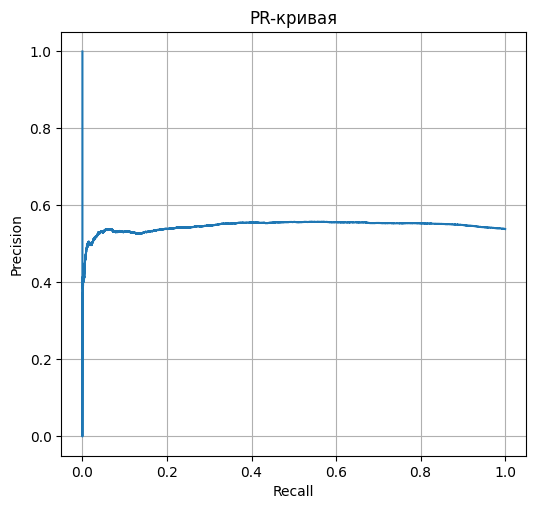

In [ ]:
# PR-кривая
valid_proba = model_LR.predict_proba(valid_X)
precision, recall, thresholds = precision_recall_curve(valid_Y, valid_proba[:, 1])

plt.figure(figsize=(6, 5.5))
plt.plot(recall, precision)
plt.title('PR-кривая')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

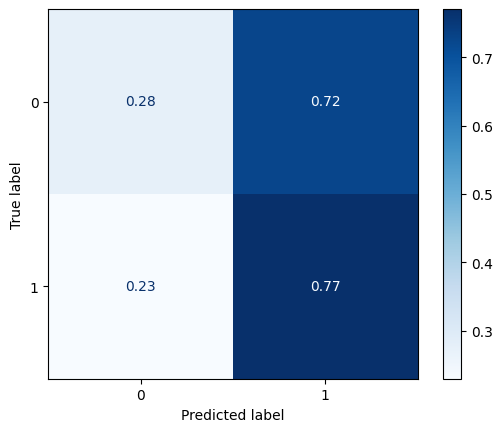

In [ ]:
# матрица ошибок
ConfusionMatrixDisplay.from_predictions(valid_Y, valid_pred, cmap=plt.cm.Blues, normalize='true');

In [ ]:
# вектор весов (w) / значимость признаков
w = pd.DataFrame(data=model_LR.coef_[0], index=valid_X.columns.T, columns=['w']).sort_values('w', ascending=False)
display(w)

,w
offer_depersonalised,0.0
169_oi,0.0
171_oi,0.0
172_oi,0.0
173_oi,0.0
...,...
213_gi,0.0
214_gi,0.0
215_gi,0.0
216_gi,0.0


Результат предсказаний - посредственный. Параметр для баланса классов не повысил, а уменьшил метрику. Из доступных вариантов solver координальных изменений не принёс не один. Максимальное значение ключевой метрики не выше 0.70

### LightGBM

In [ ]:
model_LGBM = LGBMClassifier(random_state=RANDOM_STATE, class_weight='balanced')

In [ ]:
model_LGBM.fit(train_X, train_Y)
valid_pred = model_LGBM.predict(valid_X)

print('Precision: {:.5}'.format(precision_score(valid_Y, valid_pred)))
print('Recall: {:.5}'.format(recall_score(valid_Y, valid_pred)))
print('F1: {:.5}'.format(f1_score(valid_Y, valid_pred)))

LightGBMError: bad allocation

In [ ]:
# матрица ошибок и PR-кривая
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=FIGSIZE)

ConfusionMatrixDisplay(confusion_matrix(valid_Y, valid_pred, normalize='true')).plot(ax=ax1, cmap=plt.cm.Blues)

valid_proba = model_CB.predict_proba(valid_X)
precision, recall, thresholds = precision_recall_curve(valid_Y, valid_proba[:, 1])
PrecisionRecallDisplay(precision=precision, recall=recall).plot(ax=ax2)
plt.grid(True)
plt.show()

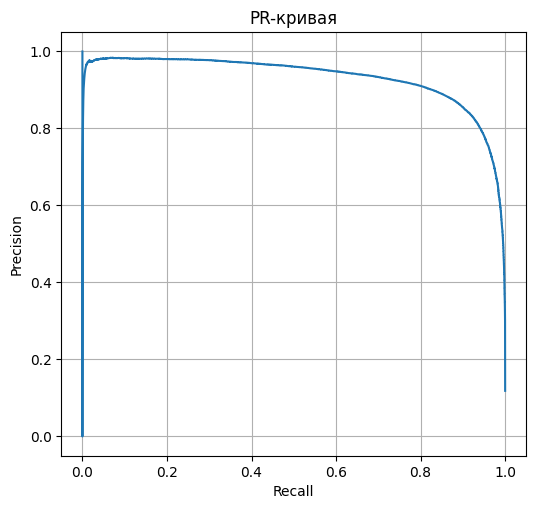

In [ ]:
# PR-кривая
valid_proba = model_LGBM.predict_proba(valid_X)
precision, recall, thresholds = precision_recall_curve(valid_Y, valid_proba[:, 1])

plt.figure(figsize=(6, 5.5))
plt.plot(recall, precision)
plt.title('PR-кривая')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.grid()
plt.show()

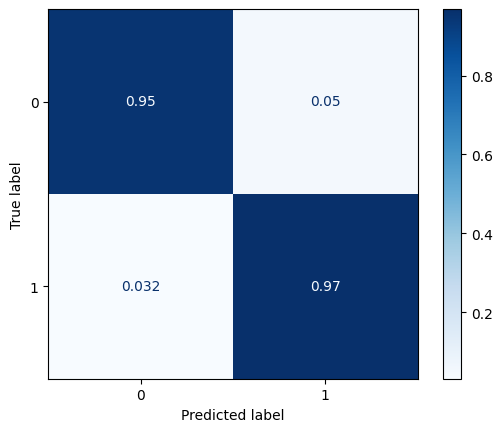

In [ ]:
# матрица ошибок
ConfusionMatrixDisplay.from_predictions(valid_Y, valid_pred, cmap=plt.cm.Blues, normalize='true');

### CatBoost

In [ ]:
model_CB = CatBoostClassifier(
    verbose = 100,
    iterations = 1000,
    task_type = 'CPU',
    eval_metric = 'F1',
    loss_function = 'Logloss',
    boosting_type = 'Plain',
    grow_policy = 'SymmetricTree', # 'SymmetricTree', 'Lossguide'
    custom_loss=['Precision', 'Recall', 'F1'],
    random_state = RANDOM_STATE)

In [ ]:
# 'SymmetricTree'
model_CB.fit(train_X, train_Y, plot=True)
valid_pred = model_CB.predict(valid_X)

print('Precision: {:.5}'.format(precision_score(valid_Y, valid_pred)))
print('Recall: {:.5}'.format(recall_score(valid_Y, valid_pred)))
print('F1: {:.5}'.format(f1_score(valid_Y, valid_pred)))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.272805
0:	learn: 0.9085846	total: 1.73s	remaining: 28m 44s
100:	learn: 0.9221299	total: 2m 13s	remaining: 19m 46s
200:	learn: 0.9259992	total: 4m 11s	remaining: 16m 39s
300:	learn: 0.9289574	total: 6m 8s	remaining: 14m 15s
400:	learn: 0.9319187	total: 8m 6s	remaining: 12m 6s
500:	learn: 0.9344911	total: 10m 3s	remaining: 10m 1s
600:	learn: 0.9367412	total: 12m	remaining: 7m 58s
700:	learn: 0.9389004	total: 13m 58s	remaining: 5m 57s
800:	learn: 0.9412550	total: 15m 53s	remaining: 3m 56s
900:	learn: 0.9430990	total: 17m 49s	remaining: 1m 57s
999:	learn: 0.9449769	total: 19m 45s	remaining: 0us
Precision: 0.90246
Recall: 0.94499
F1: 0.92323


In [ ]:
# сохранение модели
model_CB.save_model('models/CatBoost.cbm', format='cbm')

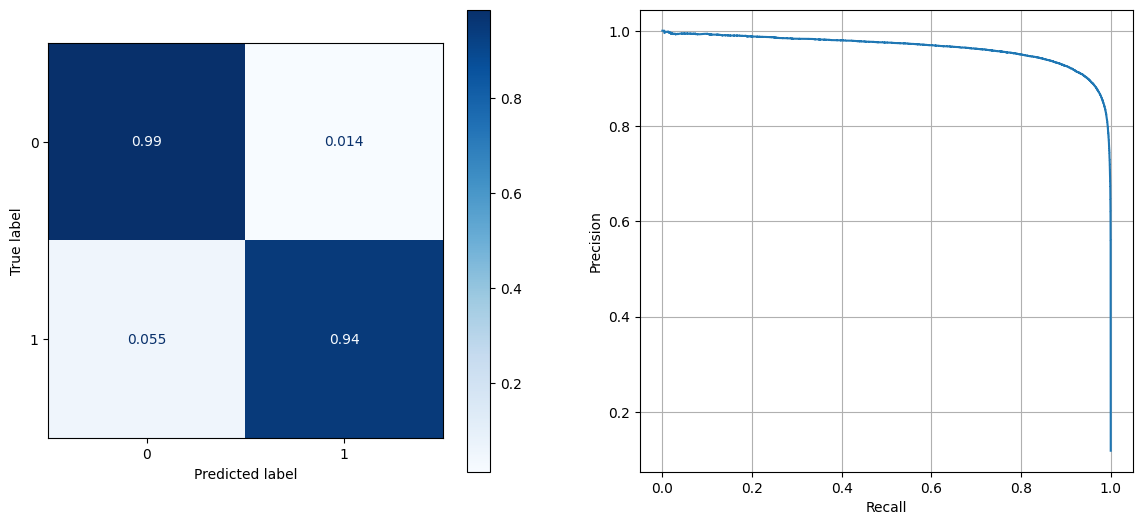

In [ ]:
# матрица ошибок и PR-кривая
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=FIGSIZE)

ConfusionMatrixDisplay(confusion_matrix(valid_Y, valid_pred, normalize='true')).plot(ax=ax1, cmap=plt.cm.Blues)

valid_proba = model_CB.predict_proba(valid_X)
precision, recall, thresholds = precision_recall_curve(valid_Y, valid_proba[:, 1])
PrecisionRecallDisplay(precision=precision, recall=recall).plot(ax=ax2)
plt.grid(True)
plt.show()

In [ ]:
# значимость признаков
w = pd.DataFrame(data=model_CB.get_feature_importance(), index=train_X.columns, columns=['w'])
display(w.sort_values('w', ascending=False).head(15))
print('Общее кол-во признаков:', len(w))
print('Кол-во "бесполезных" признаков:', len(w[w['w']==0]))

,w
73_gi,18.215677
attrs+title_score,16.566026
goods_category_id,10.946116
goods_price,6.600566
30_gi,6.546770
sum_length,4.987205
109_gi,4.852497
offer_price,2.369793
offer_depersonalised,2.275771
58_gi,2.106511


Общее кол-во признаков: 657
Кол-во "бесполезных" признаков: 6


In [ ]:
model_CB.get_feature_importance(prettified=True)

Промежуточный вывод:

- Изменение типа бустинга на более точного `Ordered` не принесло увеличение качества метрики. Но значительно увеличило время обучения с 30 минут до 3 часов, ориентировочно.
- Около 20 пар с положительным результатом мэтчинга стабильно не получается обнаружить при различных настройках.

### Анализ предсказаний

,offer_depersonalised,goods_depersonalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,target
1772116,307979,876609,0.091799,0.675781,0.000015,4.601094e-07,82.0,0
1697348,79675,137107,0.086640,0.630371,0.000009,3.817626e-07,7.0,0
2061688,532010,1500320,0.120106,0.014618,0.000008,3.399776e-07,7.0,1
1106912,332722,608888,0.052513,0.104126,0.000005,1.837588e-07,9.0,1
1250038,128858,21022,0.061508,0.004181,0.000011,2.131982e-07,6.0,1
...,...,...,...,...,...,...,...,...
2142270,187260,503562,0.131349,0.436279,0.000009,2.630553e-07,3.0,0
2071784,488317,315320,0.121429,0.082825,0.000114,5.462908e-06,2.0,0
2206563,375856,921070,0.141005,0.002684,0.000456,2.116740e-05,21.0,1
2023899,26423,241830,0.115608,0.002306,0.001260,5.982324e-05,8.0,1


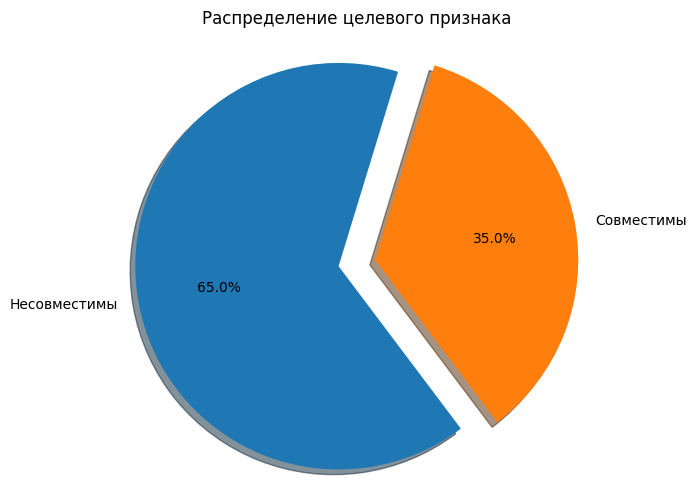

In [ ]:
# объекты с ошибочным предсказанием мэтчинга
#valid_diff_index = valid_X[valid_Y != valid_pred].index
#valid_diff = train_df.loc[valid_diff_index]

valid_diff = valid_X.loc[valid_Y != valid_pred, 'offer_depersonalised':'goods_category_id']
valid_diff = valid_diff.merge(valid_Y, left_index=True, right_index=True)

display(valid_diff)

plt.figure(figsize=FIGSIZE)
plt.pie(valid_diff['target'].value_counts(),
        labels=['Несовместимы', 'Совместимы'],
        autopct='%1.1f%%',
        startangle=73,
        explode=(0.1, 0.1),
        shadow=True,
        radius=1.10)
plt.title('Распределение целевого признака')
plt.show()

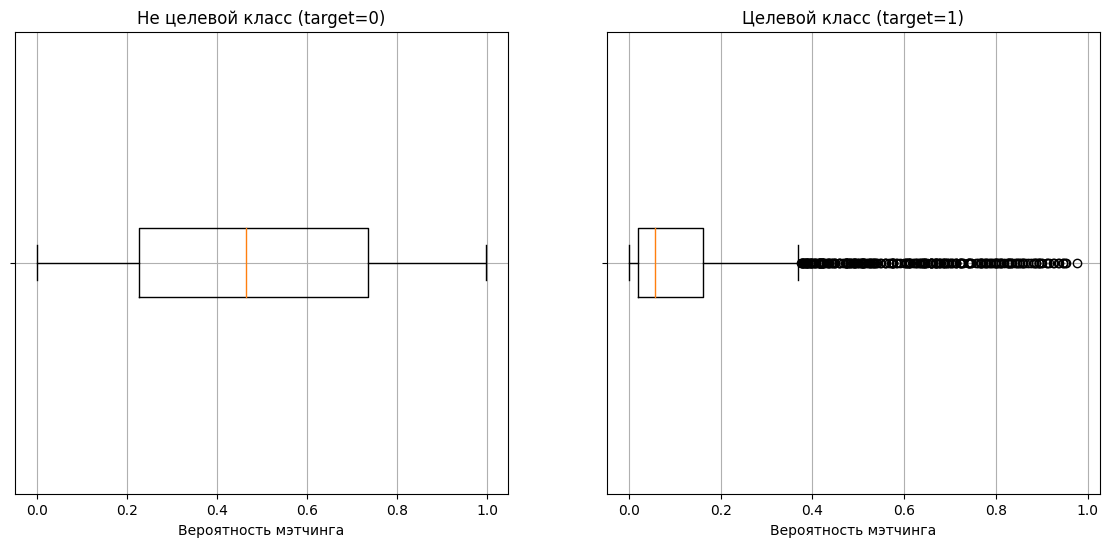

,attrs+title_score_0,attrs+title_score_1
count,4593.000000,2474.000000
mean,0.477336,0.133811
std,0.281661,0.188674
min,0.000062,0.000034
25%,0.227173,0.019531
50%,0.465088,0.056396
75%,0.735840,0.161011
max,0.996582,0.978027


In [ ]:
# распределение вероятностей мэтчинга среди ошибочных предсказаний
fig, axs = plt.subplots(1, 2, figsize=FIGSIZE)

axs[0].boxplot(valid_diff.loc[valid_diff['target']==0, 'attrs+title_score'], vert=False, labels=[''])
axs[0].set_title('Не целевой класс (target=0)')
axs[0].set_xlabel('Вероятность мэтчинга')
axs[0].grid(True)

axs[1].boxplot(valid_diff.loc[valid_diff['target']==1, 'attrs+title_score'], vert=False, labels=[''])
axs[1].set_title('Целевой класс (target=1)')
axs[1].set_xlabel('Вероятность мэтчинга')
axs[1].grid(True)
plt.show()

target_0 = valid_diff.loc[valid_diff['target']==0, 'attrs+title_score'].describe().to_frame()
target_1 = valid_diff.loc[valid_diff['target']==1, 'attrs+title_score'].describe().to_frame()
display(target_0.merge(target_1, left_index=True, right_index=True, suffixes=['_0', '_1']))

Промежуточный вывод:

Предполагаю, что качество классификатора упёрлось в качество рескоринговой модели. Вероятность `attrs+title_score` от этой модели значительно упрощает классификацию, но часть объектов имеет противоречивые данные. К примеру, большинство целевых объектов имеет вероятность мэтчинга до 30%, но при этом они совместимы. Это результат накопительной ошибки от предыдущих моделей и этапов. Её можно решить несколькими способами:

1. На предыдущем этапе повысить точность вероятности мэтчинга товаров.
2. На текущем этапе повысить значимость других признаков, которые будут выступать в роли перестраховки в таких случаях.

___

## Тест

Предварительный план:
- сформировать тестовую выборку / дополнить датасет `test.csv`
- выполнить тестовое предсказание
- запаковать в DataFrame
- сохранить в csv-формате для отправки

In [ ]:
# увеличение выборки малочисленного класса
train_Y_combined = pd.concat([train_Y] + [valid_Y])
train_X_combined = pd.concat([train_X] + [valid_X])
del train_X, train_Y, valid_X, valid_Y

# перемешивание объектов внутри выборки
features_combined, target_combined = shuffle(train_X_combined, train_Y_combined, random_state=RANDOM_STATE)

display(train_X_combined.head())
print(train_X_combined.shape)

display(train_Y_combined.to_frame().head())
print(train_Y_combined.shape)

,offer_depersonalised,goods_depersonalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,cityblock_image,euclid_image,canberra_image,...,54_ot,55_ot,56_ot,57_ot,58_ot,59_ot,60_ot,61_ot,62_ot,63_ot
0,295140,1396793,37,0.027267,1070,NaN,14.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,65291,1396586,38,0.050415,698,NaN,14.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,39232,1396244,38,0.087280,837,NaN,14.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,39232,1396513,38,0.087280,837,NaN,14.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,65052,1396237,38,0.079773,1085,NaN,14.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(2908309, 657)


,target
0,0
1,0
2,0
3,0
4,0


(2908309,)


In [ ]:
# обучение на увеличенной выборке
model_CB.fit(train_X_combined, train_Y_combined, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.310391
0:	learn: 0.8527252	total: 2.97s	remaining: 49m 30s
100:	learn: 0.8886362	total: 3m	remaining: 26m 43s
200:	learn: 0.8972169	total: 5m 44s	remaining: 22m 49s
300:	learn: 0.9031577	total: 8m 30s	remaining: 19m 44s
400:	learn: 0.9086863	total: 11m 31s	remaining: 17m 13s
500:	learn: 0.9117696	total: 14m 12s	remaining: 14m 9s
600:	learn: 0.9159325	total: 17m 10s	remaining: 11m 23s
700:	learn: 0.9190822	total: 19m 56s	remaining: 8m 30s
800:	learn: 0.9219853	total: 22m 49s	remaining: 5m 40s
900:	learn: 0.9246713	total: 25m 42s	remaining: 2m 49s
999:	learn: 0.9273635	total: 28m 29s	remaining: 0us


In [ ]:
# неявные дубликаты среди фотографий товаров
display(goods_image_df[goods_image_df.index.duplicated(keep=False)].sort_index().head(6))
print('Кол-во дублирующих фотографий:', len(goods_image_df[goods_image_df.index.duplicated()]))

print('Before:', goods_image_df.shape[0])
goods_image_df = goods_image_df[~goods_image_df.index.duplicated()]
print('After: ', goods_image_df.shape[0])

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
320,0.028976,0.730363,-1.281051,-0.100079,0.855477,2.162303,-2.450919,1.304461,0.087957,-0.561346,...,1.835589,-1.189534,-1.187329,-0.618400,-0.037176,1.723567,-0.323196,1.112901,-0.748570,0.829919
320,-1.649838,0.950786,-1.109396,0.253702,1.264648,1.496626,-1.511482,1.257492,-0.700077,-0.266071,...,0.818846,-0.181633,-2.420810,0.169975,0.404856,1.722667,-1.941895,-0.020341,1.403384,1.664825
321,-2.205180,1.248743,-1.627445,-0.877083,-0.041798,0.229910,-0.592625,2.179549,-0.265969,0.647153,...,0.282920,-1.185048,-2.767393,0.085783,-0.363956,0.810407,-1.261354,0.128255,1.922604,0.193719
321,-2.108333,1.303601,-1.656884,-0.850636,-0.141474,0.052352,-0.646520,2.422256,-0.456114,0.296800,...,0.354792,-1.239907,-2.861247,-0.110674,-0.786232,1.087877,-1.495511,0.324001,2.232999,-0.202618
587,0.109655,2.055944,1.368361,-0.238393,-0.661528,1.181042,0.273196,-0.596125,-2.899017,2.444120,...,0.184842,0.627262,0.278968,1.413151,2.997869,2.299328,1.381709,-0.504156,-1.255474,2.144972
587,2.037811,0.896891,-0.598309,-0.135401,0.413046,1.910169,1.921181,-1.345852,0.646819,0.923702,...,0.368236,1.067453,0.451685,0.354544,3.700801,-0.766567,0.678616,-2.663189,-0.197439,1.540558


Кол-во дублирующих фотографий: 5153
Before: 317707
After:  312554


In [ ]:
# создание тестовой выборки
test_X = test_df.copy()
test_X = test_X.merge(goods_image_df, left_on='goods_depersonalised', right_index=True, how='left')
test_X = test_X.merge(offer_image_df, left_on='offer_depersonalised', right_index=True, how='left', suffixes=('_gi',
                                                                                                              '_oi'))
test_X = test_X.merge(goods_title_df, left_on='goods_depersonalised', right_index=True, how='left')
test_X = test_X.merge(offer_title_df, left_on='offer_depersonalised', right_index=True, how='left', suffixes=('_gt',
                                                                                                              '_ot'))

display(test_X)

,offer_depersonalised,goods_depersonalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,id,0_gi,1_gi,...,54_ot,55_ot,56_ot,57_ot,58_ot,59_ot,60_ot,61_ot,62_ot,63_ot
0,64819,1396468,38,0.046997,368,NaN,1.400000e+01,64819$1396468,NaN,NaN,...,0.055389,-0.057739,0.106079,-0.133057,0.059143,0.005306,0.123108,-0.033997,-0.070557,0.133179
1,64819,1396235,38,0.046997,368,NaN,1.400000e+01,64819$1396235,NaN,NaN,...,0.055389,-0.057739,0.106079,-0.133057,0.059143,0.005306,0.123108,-0.033997,-0.070557,0.133179
2,64819,1396318,38,0.046997,368,NaN,1.400000e+01,64819$1396318,NaN,NaN,...,0.055389,-0.057739,0.106079,-0.133057,0.059143,0.005306,0.123108,-0.033997,-0.070557,0.133179
3,359959,1396281,40,0.060211,634,NaN,1.400000e+01,359959$1396281,NaN,NaN,...,0.017471,-0.012032,0.032013,-0.033905,0.015312,-0.116333,-0.151733,0.083740,-0.064148,0.103516
4,142700,717657,40,0.000370,14924,31840.0,2.000000e+00,142700$717657,NaN,NaN,...,0.153076,-0.010498,-0.066528,0.013924,-0.134644,-0.101135,-0.088745,0.090515,-0.039124,-0.190674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363830,122775,310950,5061,0.000036,804,NaN,2.463685e+15,122775$310950,NaN,NaN,...,-0.055084,-0.090454,0.003841,-0.050140,0.004597,-0.016617,0.036285,0.073792,-0.180176,0.141479
363831,419632,342465,5184,0.000092,332,184.0,2.463685e+15,419632$342465,NaN,NaN,...,0.135010,0.009972,0.014175,-0.203735,-0.094299,0.041077,0.091980,0.040283,0.119263,-0.041718
363832,369393,130129,5447,0.000267,660,614.0,2.463685e+15,369393$130129,NaN,NaN,...,-0.027023,0.088135,0.062683,-0.125366,0.060333,-0.077454,-0.069641,0.134766,-0.004654,0.026566
363833,24514,130142,5760,0.001467,2000,259.0,2.463685e+15,24514$130142,NaN,NaN,...,0.106018,0.072632,0.005520,0.041534,0.146362,0.166138,-0.070557,-0.082336,-0.055145,-0.088074


In [ ]:
# расстояние и угол между векторами
index_list = test_X[~test_X['0_gi'].isna() & ~test_X['0_oi'].isna()].index

test_X['cityblock_image'] = [
    distance.cityblock(vec_1, vec_2) for vec_1, vec_2 in zip(
        test_X.loc[:, '0_gi':'255_gi'].values,
        test_X.loc[:, '0_oi':'255_oi'].values)]

test_X.loc[index_list, 'euclid_image'] = [
    distance.euclidean(vec_1, vec_2) for vec_1, vec_2 in zip(
        test_X.loc[index_list, '0_gi':'255_gi'].values,
        test_X.loc[index_list, '0_oi':'255_oi'].values)]

test_X['canberra_image'] = [
    distance.canberra(vec_1, vec_2) for vec_1, vec_2 in zip(
        test_X.loc[:, '0_gt':'63_gt'].values,
        test_X.loc[:, '0_ot':'63_ot'].values)]

test_X['correlation_image'] = [
    distance.correlation(vec_1, vec_2) for vec_1, vec_2 in zip(
        test_X.loc[:, '0_gt':'63_gt'].values,
        test_X.loc[:, '0_ot':'63_ot'].values)]

test_X['cosine_image'] = [
    np.arccos(1 - distance.cosine(vec_1, vec_2)) * (180 / np.pi) for vec_1, vec_2 in zip(
        test_X.loc[:, '0_gi':'255_gi'].values,
        test_X.loc[:, '0_oi':'255_oi'].values)]


test_X['cityblock_title'] = [
    distance.cityblock(vec_1, vec_2) for vec_1, vec_2 in zip(
        test_X.loc[:, '0_gt':'63_gt'].values,
        test_X.loc[:, '0_ot':'63_ot'].values)]

test_X['euclid_title'] = [
    distance.euclidean(vec_1, vec_2) for vec_1, vec_2 in zip(
        test_X.loc[:, '0_gt':'63_gt'].values,
        test_X.loc[:, '0_ot':'63_ot'].values)]

test_X['canberra_title'] = [
    distance.canberra(vec_1, vec_2) for vec_1, vec_2 in zip(
        test_X.loc[:, '0_gt':'63_gt'].values,
        test_X.loc[:, '0_ot':'63_ot'].values)]

test_X['correlation_title'] = [
    distance.correlation(vec_1, vec_2) for vec_1, vec_2 in zip(
        test_X.loc[:, '0_gt':'63_gt'].values,
        test_X.loc[:, '0_ot':'63_ot'].values)]

test_X['cosine_title'] = [
    np.arccos(1 - distance.cosine(vec_1, vec_2)) * (180 / np.pi) for vec_1, vec_2 in zip(
        test_X.loc[:, '0_gt':'63_gt'].values,
        test_X.loc[:, '0_ot':'63_ot'].values)]


display(test_X.loc[:, 'cityblock_image':'cosine_title'].head(10))

,cityblock_image,euclid_image,canberra_image,correlation_image,cosine_image,cityblock_title,euclid_title,canberra_title,correlation_title
0,NaN,NaN,46.618727,0.961334,0.0,5.757812,0.881348,46.618727,0.961334
1,NaN,NaN,44.075444,1.040497,0.0,5.843750,0.917969,44.075444,1.040497
2,NaN,NaN,47.502381,1.175415,0.0,6.207031,0.967285,47.502381,1.175415
3,NaN,NaN,42.201563,0.998381,0.0,5.546875,0.900879,42.201563,0.998381
4,NaN,NaN,50.169393,1.088806,0.0,6.207031,0.930664,50.169393,1.088806
5,NaN,NaN,50.169393,1.088806,0.0,6.207031,0.930664,50.169393,1.088806
6,NaN,NaN,50.169393,1.088806,0.0,6.207031,0.930664,50.169393,1.088806
7,NaN,NaN,43.010528,0.960022,0.0,5.019531,0.893066,43.010528,0.960022
8,NaN,NaN,40.900700,0.855835,0.0,5.042969,0.797852,40.900700,0.855835
9,NaN,NaN,49.816048,1.156494,0.0,6.238281,0.943359,49.816048,1.156494


In [ ]:
# масштабирование
test_X[column_list] = MinMax_scaler.transform(test_X[column_list])
for begin, end in tqdm(zip(['0_gi', '0_oi', '0_gt', '0_ot'], ['255_gi', '255_oi', '63_gt', '63_ot'])):
    Standar_scaler.fit(train_X.loc[:, begin:end])
    Standar_scaler.transform(test_X.loc[:, begin:end])

display(test_X.head())

4it [01:18, 19.53s/it]


,offer_depersonalised,goods_depersonalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,id,0_gi,1_gi,...,cityblock_image,euclid_image,canberra_image,correlation_image,cosine_image,cityblock_title,euclid_title,canberra_title,correlation_title,cosine_title
0,64819,1396468,0.000132,0.046997,0.000003,NaN,14.0,64819$1396468,NaN,NaN,...,NaN,NaN,46.618727,0.961334,0.0,5.757812,0.881348,46.618727,0.961334,87.862803
1,64819,1396235,0.000132,0.046997,0.000003,NaN,14.0,64819$1396235,NaN,NaN,...,NaN,NaN,44.075444,1.040497,0.0,5.843750,0.917969,44.075444,1.040497,92.425934
2,64819,1396318,0.000132,0.046997,0.000003,NaN,14.0,64819$1396318,NaN,NaN,...,NaN,NaN,47.502381,1.175415,0.0,6.207031,0.967285,47.502381,1.175415,100.159651
3,359959,1396281,0.000397,0.060211,0.000005,NaN,14.0,359959$1396281,NaN,NaN,...,NaN,NaN,42.201563,0.998381,0.0,5.546875,0.900879,42.201563,0.998381,89.913393
4,142700,717657,0.000397,0.000370,0.000148,0.000015,2.0,142700$717657,NaN,NaN,...,NaN,NaN,50.169393,1.088806,0.0,6.207031,0.930664,50.169393,1.088806,94.186203


In [ ]:
# тестовые предсказания
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv', index_col='id')
test_submission = sample_submission.copy()
test_submission['target'] = model_CB.predict(test_X.drop('id', axis='columns'))
test_submission.to_csv(DATA_DIR + 'test_submission.csv', index_label='id')

display(test_submission)

,target
id,
64819$1396468,0
64819$1396235,0
64819$1396318,0
359959$1396281,0
142700$717657,0
...,...
122775$310950,0
419632$342465,0
369393$130129,0


## ОБЩИЙ ВЫВОД: